### XGBOOST 
Algoritmo:  XGBOOST
Variables:  dia, noche, festivos
SE probaron todas las otras variables, incluyendo info de la fecha, y destruían valor en los indicadores

In [13]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import xgboost as xgb

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta


In [14]:
dfCOESBase = pd.read_excel('DemandaCOES.xlsx', skiprows=3)
dfCOESBase = dfCOESBase[['FECHA','EJECUTADO']]
dfCOESBase['FECHA'] = pd.to_datetime(dfCOESBase['FECHA'], format='%d/%m/%Y %H:%M')
# devolvemos todo 30 minutos para que asi no tengamos fechas del dia siguiente.
# antes del cambio  las 14:00 implicaban datos desde las 13:30 hasta las 14.  Luego del cambio significará desde las 14 hasta las 14:30
dfCOESBase['FECHA']= dfCOESBase['FECHA'] - pd.Timedelta(minutes=30)
dfCOESBase['Mes'] = dfCOESBase['FECHA'].dt.month
dfCOESBase['ano'] = dfCOESBase['FECHA'].dt.year
dfCOESBase['fechaYYYYMMDD'] = dfCOESBase['FECHA'].dt.strftime('%Y-%m-%d')
dfCOESBase['fechaYYYYMMDD'] = pd.to_datetime(dfCOESBase['fechaYYYYMMDD'])
dfCOESBase['real'] = dfCOESBase['EJECUTADO']

dfCOESNoche = dfCOESBase[(dfCOESBase['FECHA'].dt.hour >= 17) & (dfCOESBase['FECHA'].dt.hour < 23)].copy()
dfCOESNoche = dfCOESNoche.groupby('fechaYYYYMMDD')['EJECUTADO'].max().reset_index()
dfCOESNoche.rename(columns={'EJECUTADO': 'Noche'}, inplace=True)

# DIA: se toma solo el máximo de las madrugada hasta las 2pm (incluida)
dfCOESDia = dfCOESBase[(dfCOESBase['FECHA'].dt.hour >= 0) & (dfCOESBase['FECHA'].dt.hour < 14)].reset_index().copy()
dfCOESDia= dfCOESDia.groupby('fechaYYYYMMDD')['EJECUTADO'].max().reset_index()
dfCOESDia.rename(columns={'EJECUTADO': 'Dia'}, inplace=True)

dfCOESTarde = dfCOESBase[(dfCOESBase['FECHA'].dt.hour >= 14) & (dfCOESBase['FECHA'].dt.hour < 17)].reset_index().copy()
dfCOESTarde= dfCOESTarde.groupby('fechaYYYYMMDD')['EJECUTADO'].max().reset_index()
dfCOESTarde.rename(columns={'EJECUTADO': 'Tarde'}, inplace=True)

# dfCOESTotal tiene los datos de DIA y NOCHE 
dfCOESTotal = pd.merge(dfCOESDia, dfCOESTarde, on='fechaYYYYMMDD', how='left')
dfCOESTotal = pd.merge(dfCOESTotal, dfCOESNoche, on='fechaYYYYMMDD', how='left')


# OJO, QUITAMOS LOS DATOS ANTERIORES AL 2021 PUES SON MUY ATIPICOS
dfCOESTotal = dfCOESTotal[dfCOESTotal['fechaYYYYMMDD'] >= '2021-01-01']

dfCOESTotal['ano'] = dfCOESTotal['fechaYYYYMMDD'].dt.year
dfCOESTotal['mes'] = dfCOESTotal['fechaYYYYMMDD'].dt.month

dfCOESTotal = dfCOESTotal.reset_index(drop=True)

In [15]:
dfCOESTotal

fechaYYYYMMDD         Dia       Tarde       Noche   ano  mes
0       2021-01-01  5733.86802  5403.67242  6068.57125  2021    1
1       2021-01-02  6286.83420  6137.84505  6541.48328  2021    1
2       2021-01-03  5854.06243  5882.37893  6526.14883  2021    1
3       2021-01-04  6630.26567  6695.74558  6744.20894  2021    1
4       2021-01-05  6765.53126  6729.17856  6834.35502  2021    1
...            ...         ...         ...         ...   ...  ...
1185    2024-03-31  6576.77453  6524.72391  7223.41316  2024    3
1186    2024-04-01  7663.10715  7716.05489  7548.07212  2024    4
1187    2024-04-02  7812.72365  7641.14840  7561.78331  2024    4
1188    2024-04-03  7658.46944  7676.32068  7514.04914  2024    4
1189    2024-04-04  7738.48482  7671.79108         NaN  2024    4

[1190 rows x 6 columns]

### **Simulamos para varios dias**

In [54]:
fechaAnalisisMinima = pd.to_datetime('2023-11-01 14:00')
fechaAnalisisMaxima = pd.to_datetime('2024-12-31 14:00')

# el vector listaResultadosFinales (fecha, esPico) indica los resultados para cada dia analizado
listaResultadosFinales = []


listaFechasTotales = []
listaHorizontesTotales = []
listaYPredsTotales = []


dfFinalAcumulado = pd.DataFrame(columns=['fechaAnalisis', 'fecha','prediccion','real'])
dfFinalAcumulado['fechaAnalisis'] = pd.to_datetime(dfFinalAcumulado['fechaAnalisis'])
dfFinalAcumulado['fecha'] = pd.to_datetime(dfFinalAcumulado['fecha'])
dfFinalAcumulado['prediccion'] = dfFinalAcumulado['prediccion'].astype(float)
dfFinalAcumulado['real'] = dfFinalAcumulado['real'].astype(float)

dfFestivos = pd.read_excel('Festivos peru.xlsx')
dfFestivos = dfFestivos[['diaYYYYMMDD']]
dfFestivos = dfFestivos.rename(columns ={'diaYYYYMMDD':'festivo'})
dfFestivos['festivo'] = pd.to_datetime(dfFestivos['festivo'], format='%Y%m%d')

fechaAnalisis = fechaAnalisisMinima
while fechaAnalisis <= fechaAnalisisMaxima:

    print('analizando ', fechaAnalisis)

    # para una correcta simulación aseguramos que solo tengan acceso a la data anterior o igual a fechaAnalisis
    # y hasta dos años atrás. 
    dfCOES = dfCOESTotal[(dfCOESTotal['fechaYYYYMMDD'] <= fechaAnalisis) 
                        & (dfCOESTotal['fechaYYYYMMDD'] > fechaAnalisis - pd.DateOffset(years=2)) ].copy()


    # dfCobre = pd.read_excel('datosCobre.xlsx')
    # dfCobre = dfCobre[['fecha','valor']]
    # dfCobre = dfCobre.rename(columns={'valor':'cobre'})

    # dfCobre['fecha'] = pd.to_datetime(dfCobre['fecha'])
    # dfCobre['ano'] = dfCobre['fecha'].dt.year
    # dfCobre['Mes'] = dfCobre['fecha'].dt.month
    # dfCobre['cobre'] = dfCobre['cobre'].replace('n.d.', 0)

    # dfCobre['cobre'] = dfCobre['cobre'].astype(float)
    # dfCobre['cobre'] = dfCobre['cobre'].fillna(0)
    # dfCobre = dfCobre.groupby(['ano', 'Mes'])['cobre'].agg(['min','max','mean']).reset_index()

    # vamos a mover los datos un mes hacia adelante tal que cuando se haga el cruce
    # con df, este tenga el valor del mes anterior realmente.

    # dfCobre['Mes'] = dfCobre['Mes'] + 1
    # dfCobre.loc[dfCobre['Mes']==13, 'ano'] = dfCobre['ano'] + 1
    # dfCobre.loc[dfCobre['Mes']==13, 'Mes'] = 1

    # dfCobre = dfCobre.rename(columns={'min':'minCobre','max':'maxCobre','mean':'meanCobre'})

    df = dfCOES.copy()
    df.reset_index(drop=True, inplace=True)   

    df['diaDelMes'] = df['fechaYYYYMMDD'].dt.day
    df['Mes'] = df['fechaYYYYMMDD'].dt.month
    df['Trimestre'] = df['fechaYYYYMMDD'].dt.quarter
    df['ano'] = df['fechaYYYYMMDD'].dt.year
    df['diaDeLaSemana'] = df['fechaYYYYMMDD'].dt.dayofweek
    df['diaDelAno'] = df['fechaYYYYMMDD'].dt.dayofyear
    df['semanaDelAno'] = df['fechaYYYYMMDD'].dt.isocalendar().week

    # df = df.merge(dfCobre, on=['ano','Mes'], how='left')

    def verificaFestivo(fecha):
        if fecha in dfFestivos['festivo'].values:
            return 1
        return 0

    df['festivo'] = df['fechaYYYYMMDD'].apply(verificaFestivo)

    # convierte la data a numpy, con una historia "historia" valores para cada variable
    # y se genera un "y" con un horizonte en dias a futuro.  Horizonte= 0 predice la noche
    # del dia i.   horizonte=1 predice la siguiente noche y así sucesivamente.

    # OJO:  data1 y data2 traen no solo training sino la fila a predecir, que es la última.

    def df_a_numpy(data1, data2, data3, historia, horizonte):
        X0, X1, X2,  y = [], [], [], []

        iMax = len(data1) - historia - horizonte -1

        for i in range(iMax+1):   # el for en python llega hasta iMax RECORDAR!!!
            X0.append(data1[i:i+historia +1])     # DIA.  OJO, LAS SERIES traen una menos del final
            X1.append(data2[i:i+historia])   #  sin incluir la TARDE del dia de hoy
            X2.append(data3[i:i+historia])   #  sin incluir la NOCHE del dia de hoy
            y.append(data3[i+historia + horizonte])  # si horizo=0, se predice la Noche actual
        return np.array(X0), np.array(X1), np.array(X2), np.array(y)


    # Definir los parámetros del modelo XGBoost
    params = {
        'colsample_bytree':0.8,
        'learning_rate':0.1,
        'max_depth':5,
        'n_estimators': 400,
        'subsample':0.8
    }

    # Inicializar el regresor XGBoost
    regressor = xgb.XGBRegressor(**params)

    historia = 364

    # fecha = pd.to_datetime('2023-01-01')
    fecha = fechaAnalisis

    # fechaMaxima = pd.to_datetime('2024-02-29')

    listaFechas = []
    listaHorizontes = []
    listaYPreds = []

    # Calculamos cuantos dias faltan para que termine el mes
    ultimoDia = datetime(year=fecha.year, month=fecha.month, day=1)   # vamos al primer dia del mes

    ultimoDia = ultimoDia + relativedelta(months=1)  # adicionamos un mes y tenemos el primer dia del mes siguiente
    # ultimoDia = ultimoDia - relativedelta(days=1)  # OJO QUITO ESTO PARA PROBAR SI ES QUE ES ASI QUE DA BUENOS RESULTADOS

    diasFaltantes = (ultimoDia - fecha).days

    for horizonte in range(0, diasFaltantes+1):   # se predicen 30 dias en el peor caso

        # OJO, LA ULTIMA FILA - HORIZONTE ES PARA PREDICCION!!
        # EL RESTO SI ES PARA TRAININ

        X0 , X1,  X2, y = df_a_numpy(df['Dia'], df['Tarde'], df['Noche'], historia, horizonte) 
        X3 = (df.loc[historia + horizonte:, ['festivo']] == 'festivo').astype(int)

        # df['diaDelMes'] = df['fechaYYYYMMDD'].dt.day
        X4 = df.loc[historia + horizonte:, ['diaDelMes']]
        
        # df['Mes'] = df['fechaYYYYMMDD'].dt.month
        X5 = df.loc[historia + horizonte:, ['Mes']]

        # df['Trimestre'] = df['fechaYYYYMMDD'].dt.quarter
        X6 = df.loc[historia + horizonte:, ['Trimestre']]

        # df['ano'] = df['fechaYYYYMMDD'].dt.year
        # df['diaDeLaSemana'] = df['fechaYYYYMMDD'].dt.dayofweek
        X7 = df.loc[historia + horizonte:, ['diaDeLaSemana']]

        # df['diaDelAno'] = df['fechaYYYYMMDD'].dt.dayofyear
        X8 = df.loc[historia + horizonte:, ['diaDelAno']]

        # df['semanaDelAno'] = df['fechaYYYYMMDD'].dt.isocalendar().week
        X9 = df.loc[historia + horizonte:, ['semanaDelAno']]

        print('horizonte:', horizonte)
        X = np.concatenate((X0, X1, X2, X3, X4, X5, X6, X7, X8, X9), axis=-1)

        # X0Train = X0[:-1 , :]
        # X1Train = X1[:-1 , :]
        # yTrain = y[:-1 ]

        # X0Pred = X0[-1, :]
        # X1Pred = X1[-1, :]

        # X = np.concatenate((X0, X1), axis=-1)

        XTrain = X[:-1, :]  # todas menos la última fila
        yTrain = y[:-1]  # todas menos la ultima fila

        XPred = X[-1:, :]

        # # Entrenamos el modelo con dos años atras
        # fechaAPredecir = fecha + timedelta(days=horizonte)
        # yNumpy, indiceNumPy= valorEnNumPyDadoFechaDF(fecha, historia, horizonte)
        
        # se entrena el modelo con dos años de antigüedad 360*2
        # XTrain = X[indiceNumPy-360*2:indiceNumPy+1]
        # yTrain = y[indiceNumPy-360*2:indiceNumPy+1]

        regressor.fit(XTrain, yTrain)

        # # Predicción
        # XTest = X[indiceNumPy: indiceNumPy + 1]
        # yTest = y[indiceNumPy: indiceNumPy + 1]

        yPred = regressor.predict(XPred)

        listaFechas.append(fecha)
        listaHorizontes.append(horizonte)
        listaYPreds.append(yPred[0])

    listaFechasTotales.extend(listaFechas)
    listaHorizontesTotales.extend(listaHorizontes)
    listaYPredsTotales.extend(listaYPreds)

    # dfPrediccion =pd.DataFrame({'fecha': listaFechas, 'horizonte': listaHorizontes, 'prediccion': listaYPreds})
    # dfPrediccion.rename(columns={'fecha': 'fechaAnalisis'}, inplace=True)
    # dfPrediccion['fechaAnalisis'] = pd.to_datetime(fechaAnalisis.strftime('%Y-%m-%d'))
    # dfPrediccion['fecha'] = dfPrediccion['fechaAnalisis'] + pd.to_timedelta(dfPrediccion['horizonte'], unit='D')
    # dfPrediccion['real'] = 0.0
    # dfPrediccion = dfPrediccion[['fechaAnalisis','fecha','prediccion', 'real']]

    # primer_dia_mes = fechaAnalisis.replace(day=1)
    # dfReal = dfCOESTotal[(dfCOESTotal['fechaYYYYMMDD'] >= primer_dia_mes.strftime('%Y-%m-%d'))
    #                 & (dfCOESTotal['fechaYYYYMMDD'] < fechaAnalisis.strftime('%Y-%m-%d'))].copy()
    # dfReal['fecha'] = dfReal['fechaYYYYMMDD']
    # dfReal['real'] = dfReal['Noche']
    # dfReal['prediccion'] = 0.0
    # dfReal['fechaAnalisis'] = pd.to_datetime(fechaAnalisis.strftime('%Y-%m-%d'))
    # dfReal = dfReal[['fechaAnalisis','fecha','prediccion', 'real']]

    # dfFinal = pd.concat([dfPrediccion, dfReal], ignore_index=True)

    # dfFinalAcumulado = pd.concat([dfFinal, dfFinalAcumulado], ignore_index=True)

    fechaAnalisis = fechaAnalisis + timedelta(days=1)

    

analizando  2023-11-01 14:00:00
horizonte: 0
horizonte: 1
horizonte: 2
horizonte: 3
horizonte: 4
horizonte: 5
horizonte: 6
horizonte: 7
horizonte: 8
horizonte: 9
horizonte: 10


KeyboardInterrupt: 

In [47]:
faMs = '2024-01-31'

In [48]:
fams = fechaAnalisisMinima.strftime("%Y-%m-%d")
# faMs = fechaAnalisisMaxima.strftime("%Y-%m-%d")
archivoDfPrediccion = 'dfPrediccion lstmv2 ' + str(historia) + ' ' + fams + ' ' + faMs + '.xlsx'
archivoDfPrediccion

'dfPrediccion lstmv2 120 2023-11-01 2024-01-31.xlsx'

In [49]:
dfPrediccion =pd.DataFrame({'fecha': listaFechasTotales, 'horizonte': listaHorizontesTotales, 'prediccion': listaYPredsTotales})
dfPrediccion.to_excel(archivoDfPrediccion)

In [50]:
dfPrediccion

fecha  horizonte   prediccion
0    2023-11-01 14:00:00          0  6897.967773
1    2023-11-01 14:00:00          1  7173.534180
2    2023-11-01 14:00:00          2  7325.653320
3    2023-11-01 14:00:00          3  7316.734863
4    2023-11-01 14:00:00          4  7268.234375
...                  ...        ...          ...
1452 2024-01-29 14:00:00          1  7447.183594
1453 2024-01-29 14:00:00          2  7453.941406
1454 2024-01-30 14:00:00          0  7540.620605
1455 2024-01-30 14:00:00          1  7576.205078
1456 2024-01-31 14:00:00          0  7581.954102

[1457 rows x 3 columns]

# **OJO - SE VA A LEER UN dfPredicciones.xlsx CALCULADO EN EL PASASO!!!

In [25]:
dfPrediccion = pd.read_excel(archivoDfPrediccion)
dfPrediccion

Unnamed: 0               fecha  horizonte   prediccion
0              0 2023-11-01 14:00:00          0  6874.529297
1              1 2023-11-01 14:00:00          1  7099.926758
2              2 2023-11-01 14:00:00          2  7213.427246
3              3 2023-11-01 14:00:00          3  7240.506348
4              4 2023-11-01 14:00:00          4  7276.633789
...          ...                 ...        ...          ...
2383        2383 2024-03-29 14:00:00          1  7560.818359
2384        2384 2024-03-29 14:00:00          2  7554.560059
2385        2385 2024-03-30 14:00:00          0  7167.850586
2386        2386 2024-03-30 14:00:00          1  7346.114258
2387        2387 2024-03-31 14:00:00          0  7263.874512

[2388 rows x 4 columns]

In [51]:
dfPrediccion = dfPrediccion[['fecha','horizonte','prediccion']].copy()
dfPrediccion.rename(columns={'fecha': 'fechaAnalisis'}, inplace=True)
dfPrediccion['fechaAnalisis'] = dfPrediccion['fechaAnalisis'].dt.date
dfPrediccion['fechaAnalisis'] = pd.to_datetime(dfPrediccion['fechaAnalisis'])
dfPrediccion['fecha'] = dfPrediccion['fechaAnalisis'] + pd.to_timedelta(dfPrediccion['horizonte'], unit='D')
dfPrediccion = dfPrediccion[['fechaAnalisis','fecha','prediccion']]
dfPrediccion.head()

fechaAnalisis      fecha   prediccion
0    2023-11-01 2023-11-01  6897.967773
1    2023-11-01 2023-11-02  7173.534180
2    2023-11-01 2023-11-03  7325.653320
3    2023-11-01 2023-11-04  7316.734863
4    2023-11-01 2023-11-05  7268.234375

Para cada fechaAnalisis, completamos el mes con los dias que faltan.

In [52]:
dfReal = dfPrediccion[dfPrediccion['prediccion']==-1]
dfReal['real'] = dfReal['prediccion']
dfReal = dfReal.drop(columns=['prediccion'])

for fechaAnalisis in dfPrediccion['fechaAnalisis'].unique():

    primerDiaMes = fechaAnalisis.replace(day=1)
    ultimoDiaMes = primerDiaMes + pd.offsets.MonthEnd(1)

    dfTemp = dfCOESTotal[(dfCOESTotal['fechaYYYYMMDD'] >= primerDiaMes) & 
                         (dfCOESTotal['fechaYYYYMMDD'] <= ultimoDiaMes)].copy()
    dfTemp['fecha'] = dfTemp['fechaYYYYMMDD']
    dfTemp['real'] = dfTemp['Noche']
    dfTemp['fechaAnalisis'] = fechaAnalisis

    dfTemp = dfTemp[['fechaAnalisis','fecha','real']]

    dfReal = pd.concat([dfReal, dfTemp], ignore_index=True)


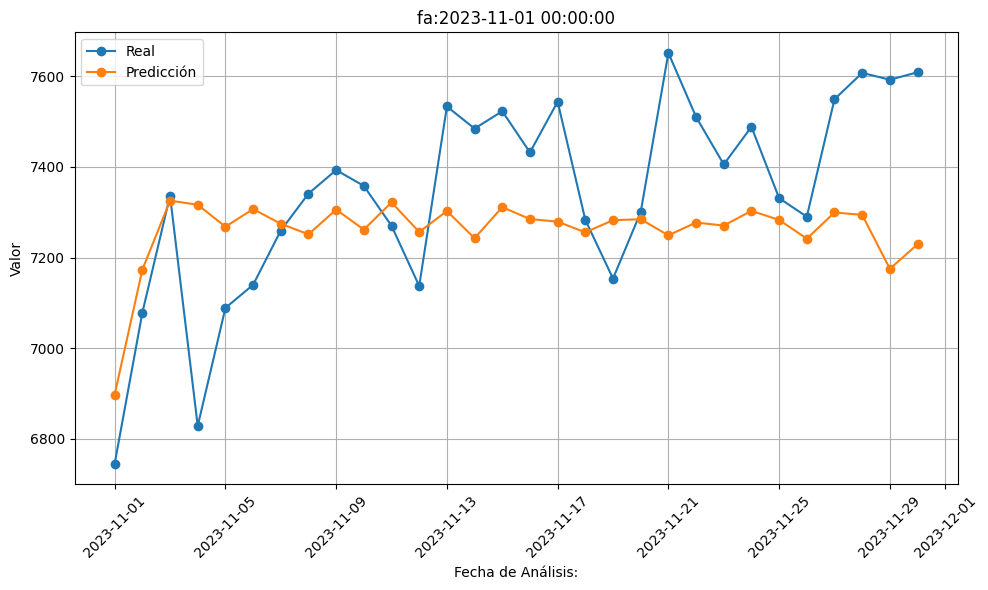

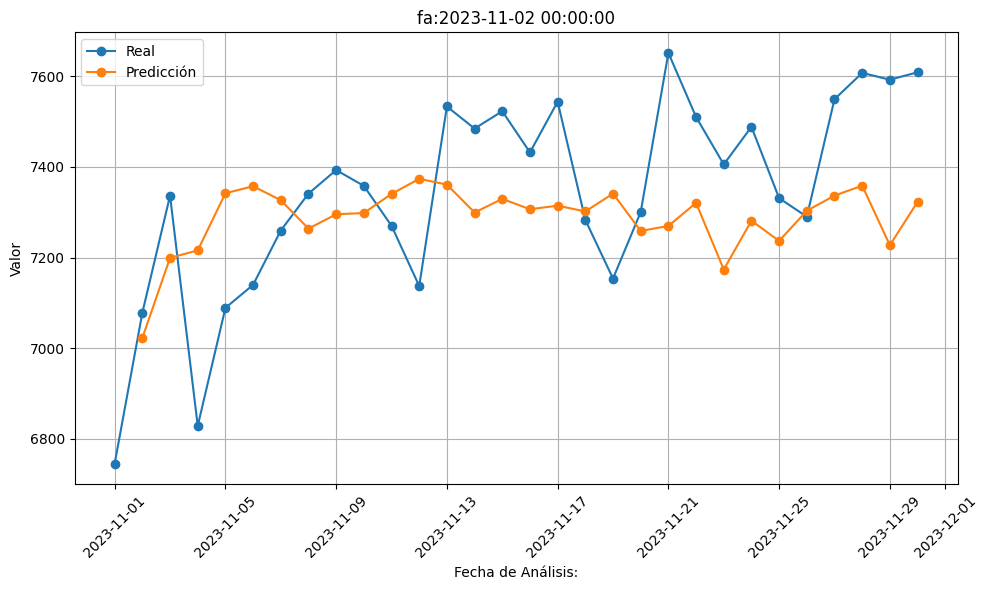

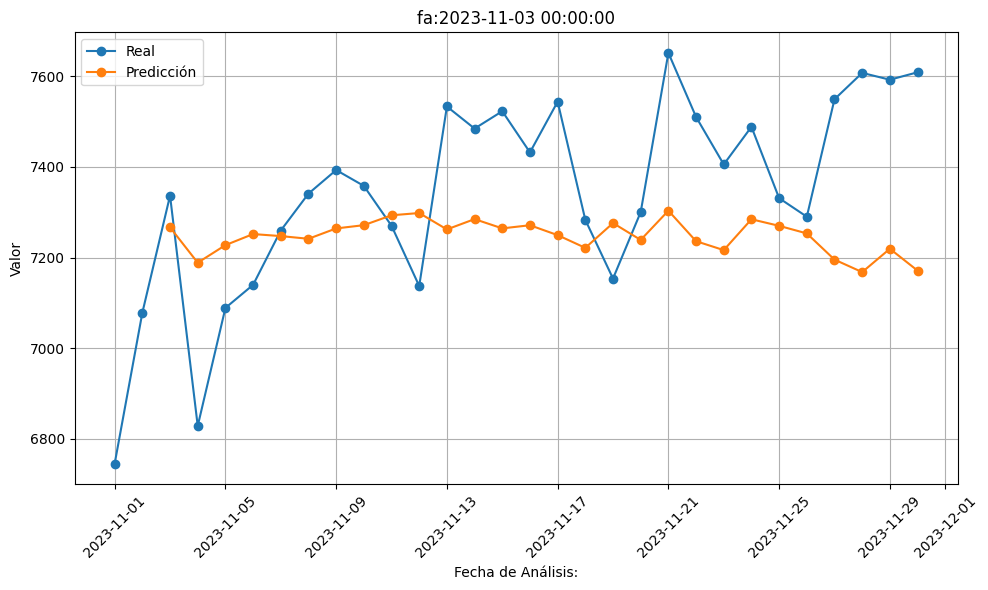

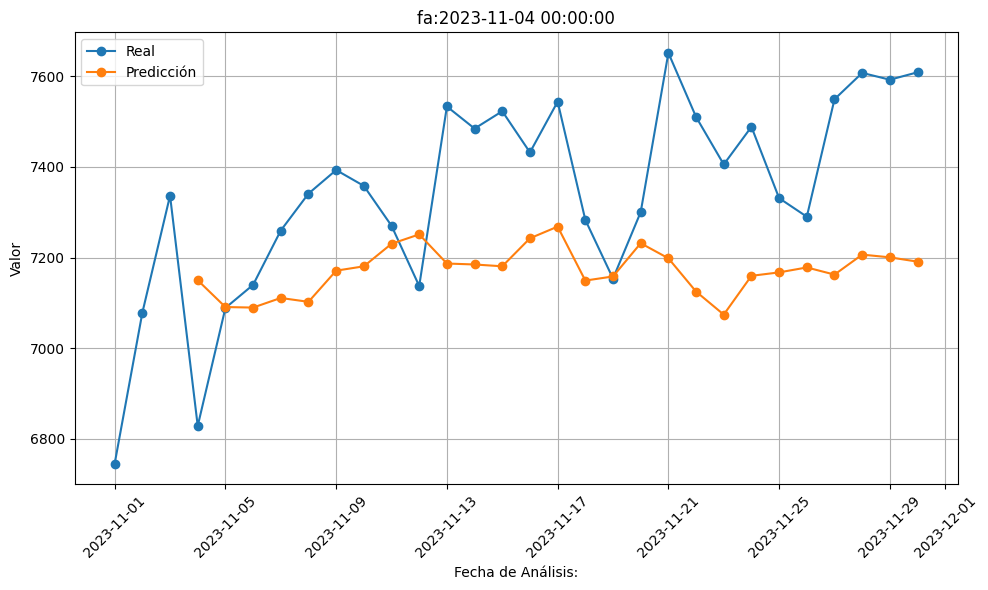

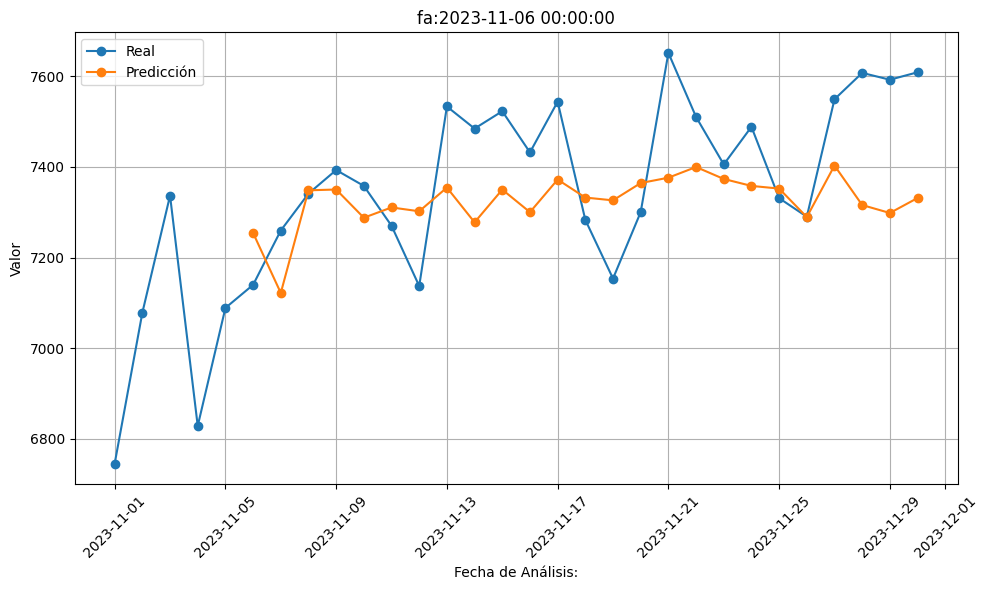

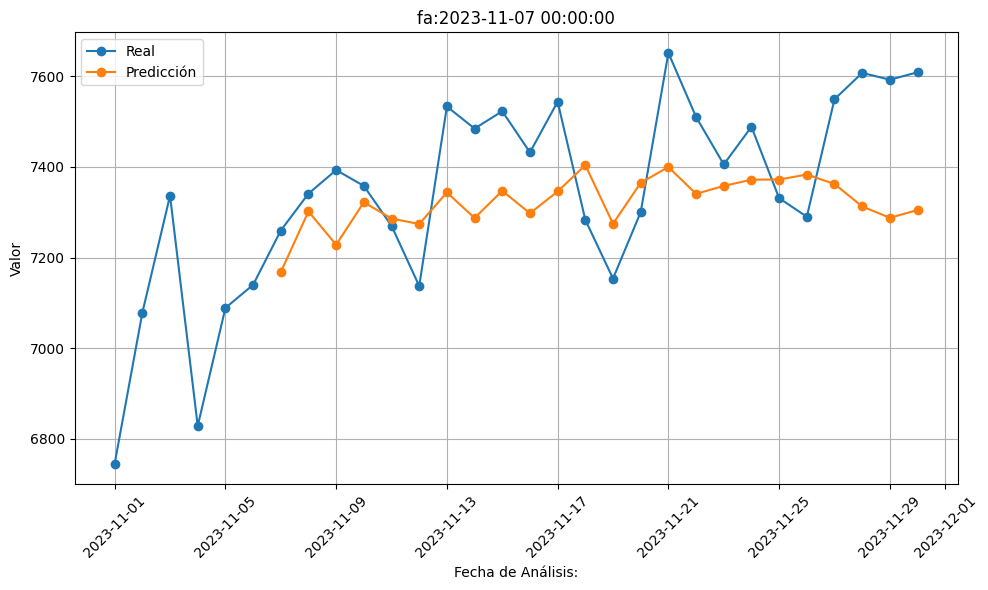

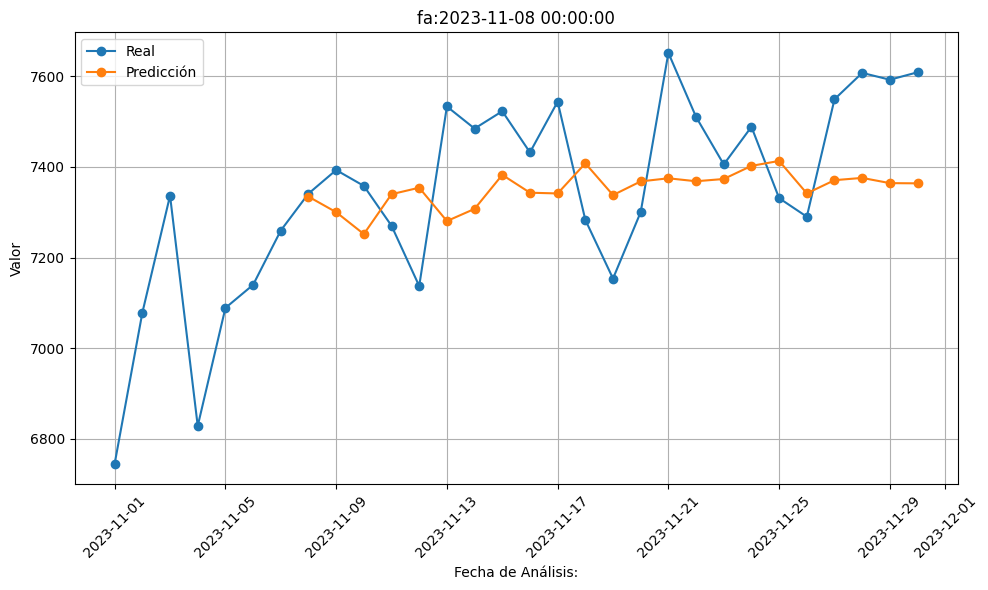

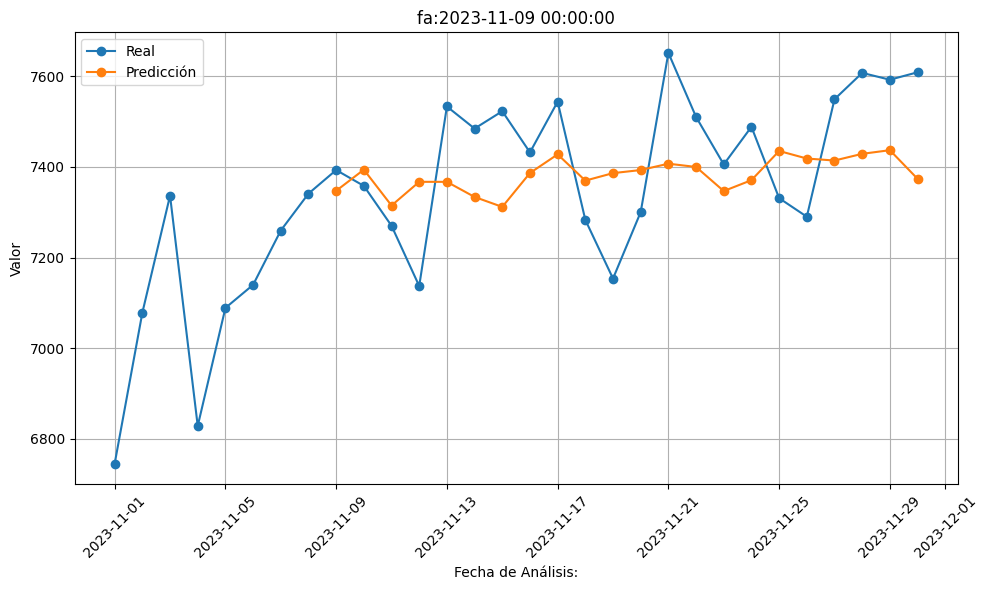

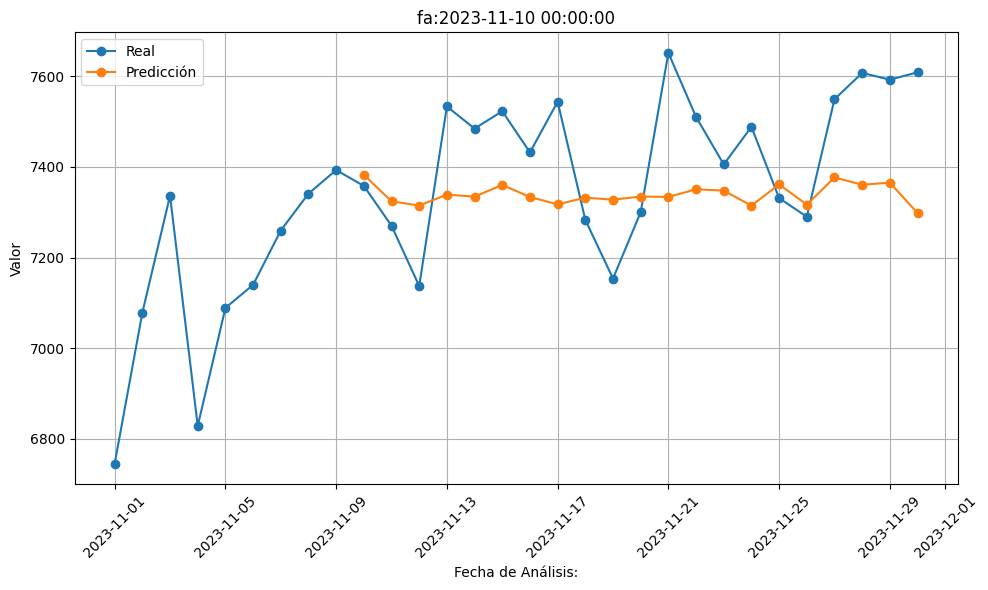

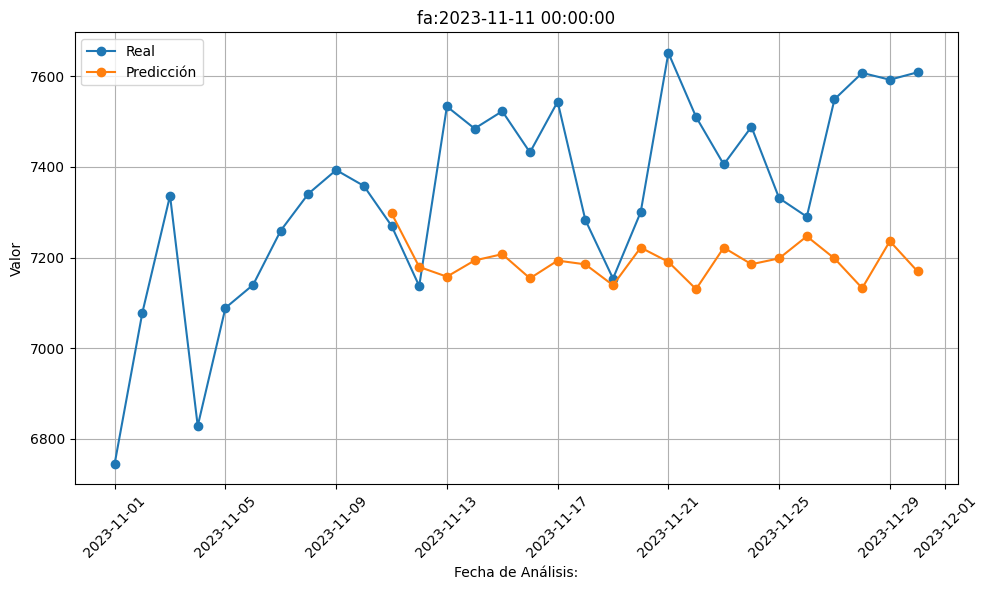

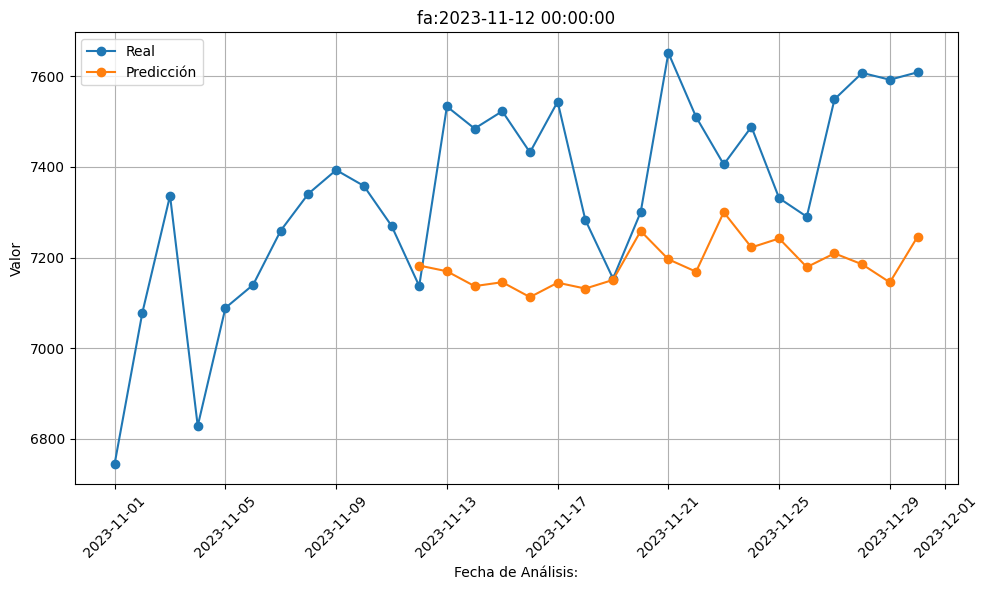

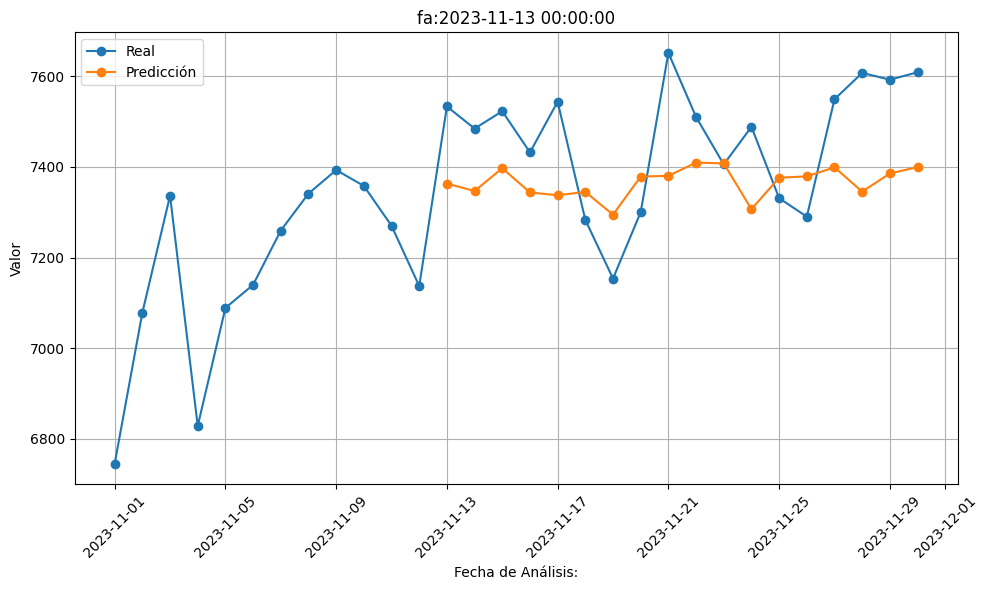

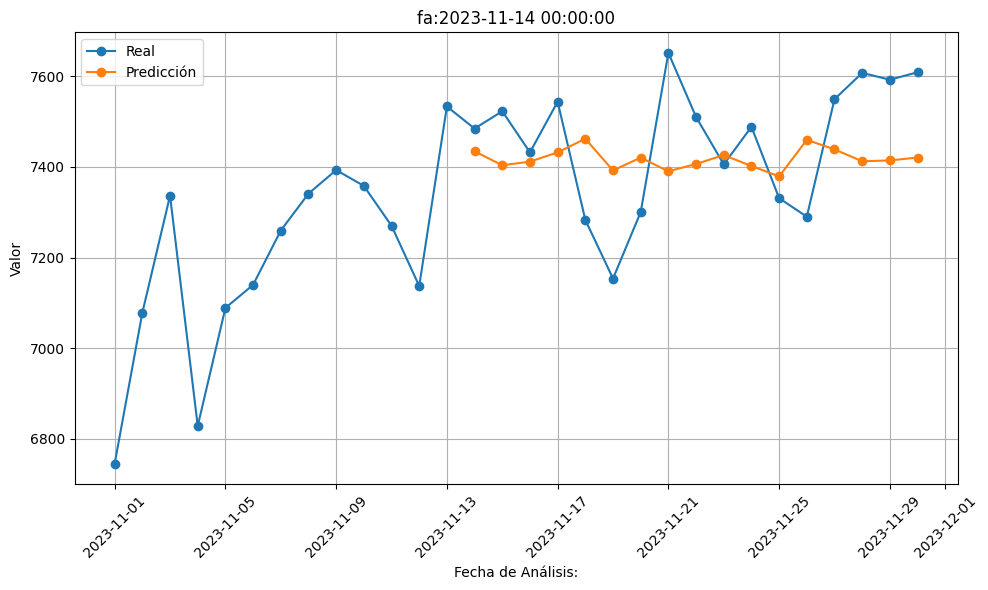

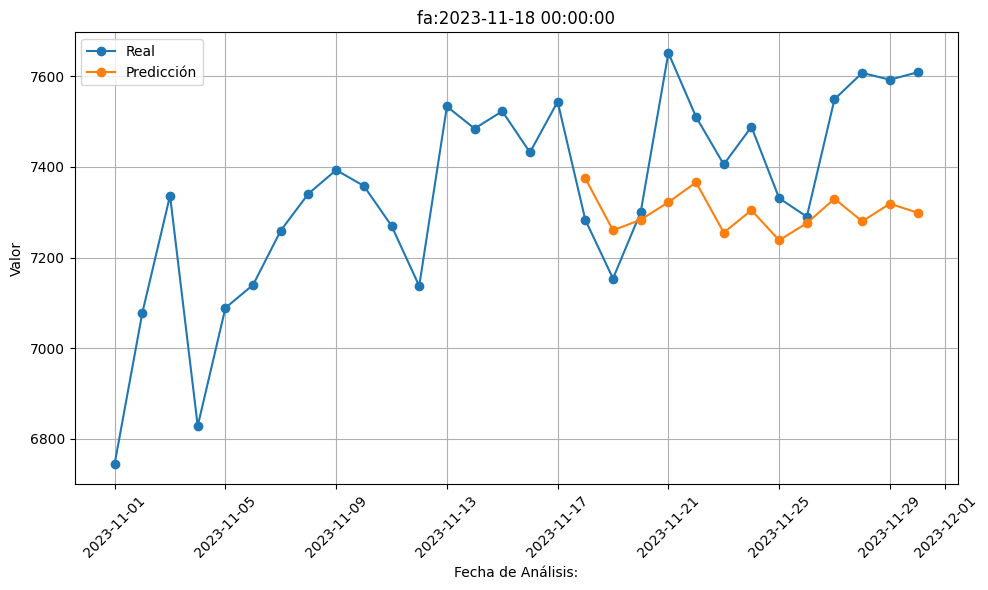

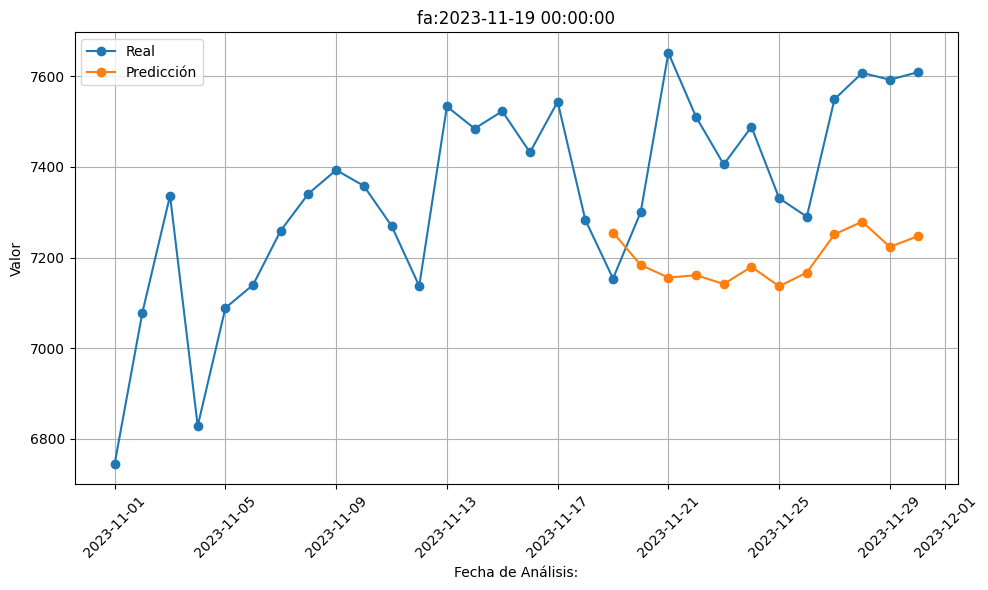

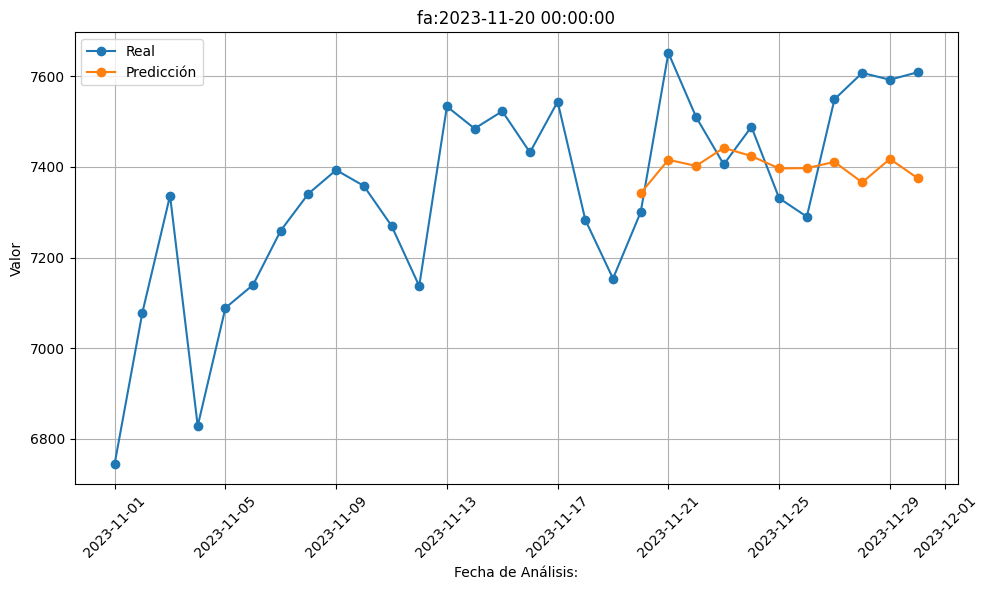

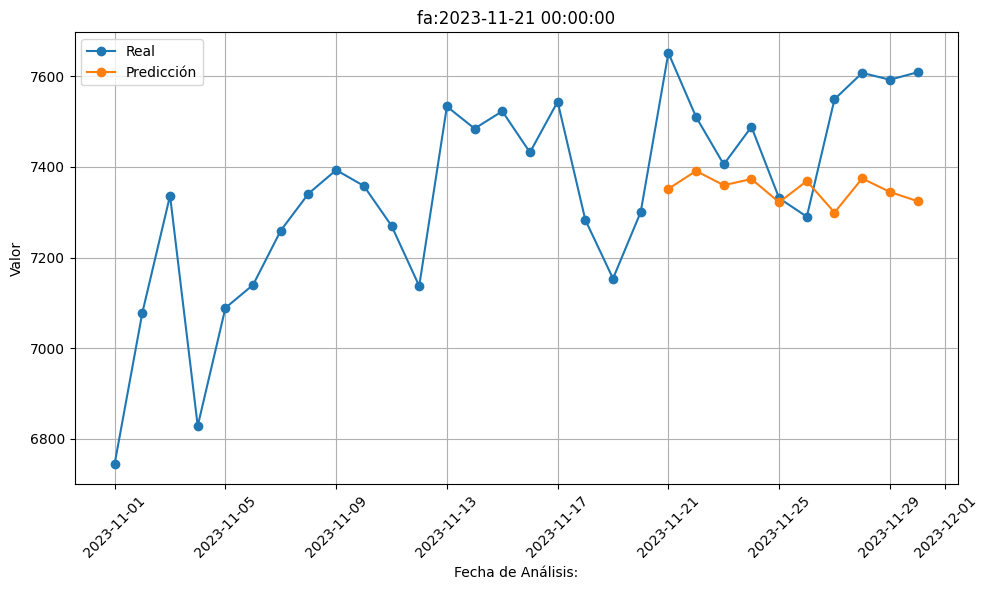

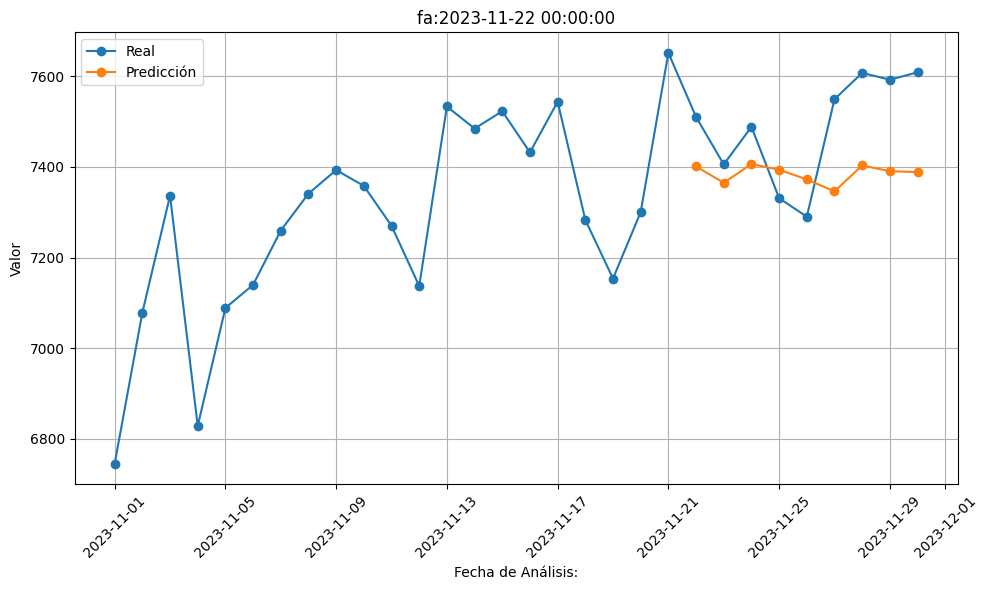

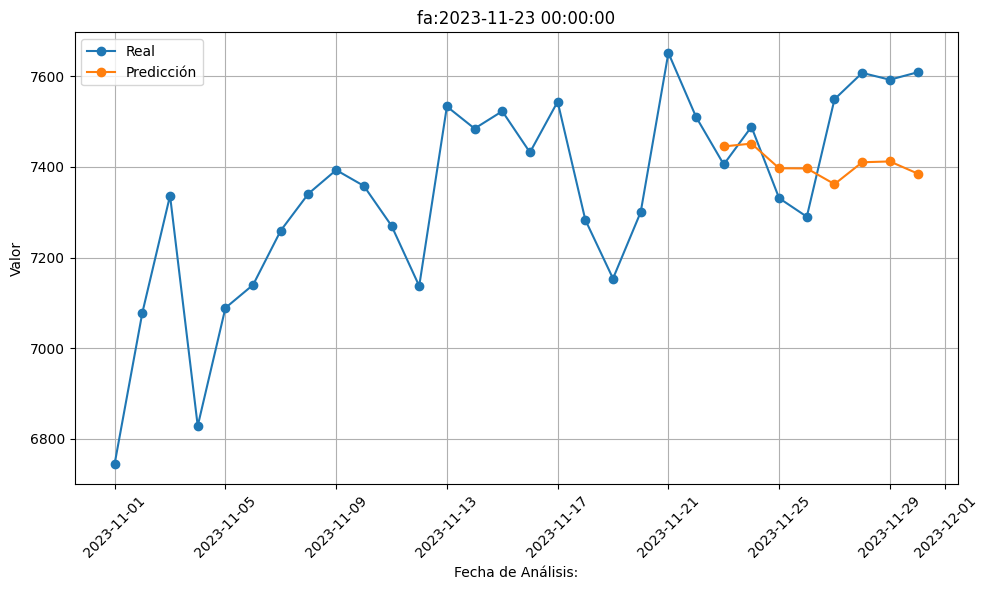

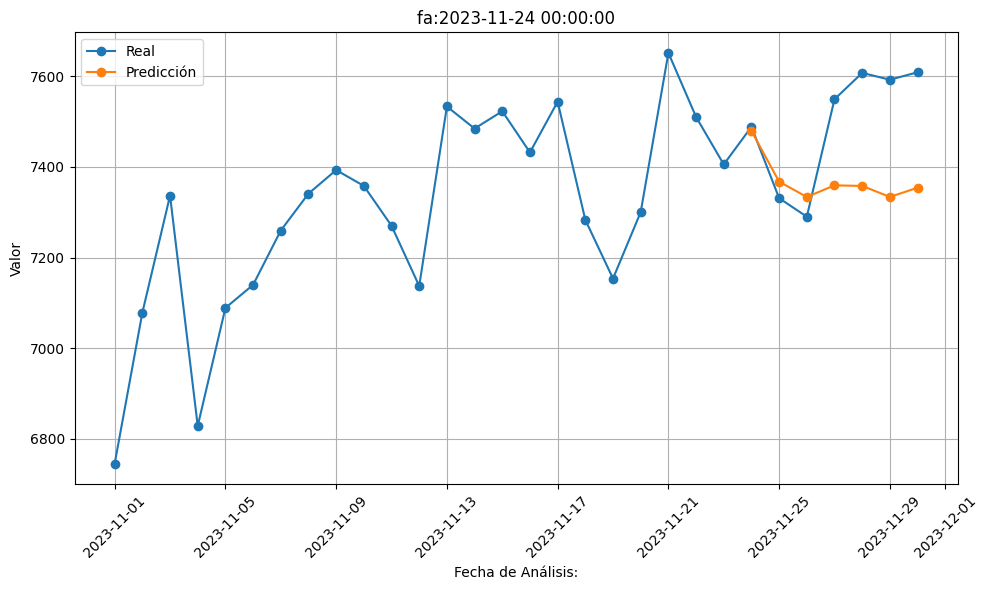

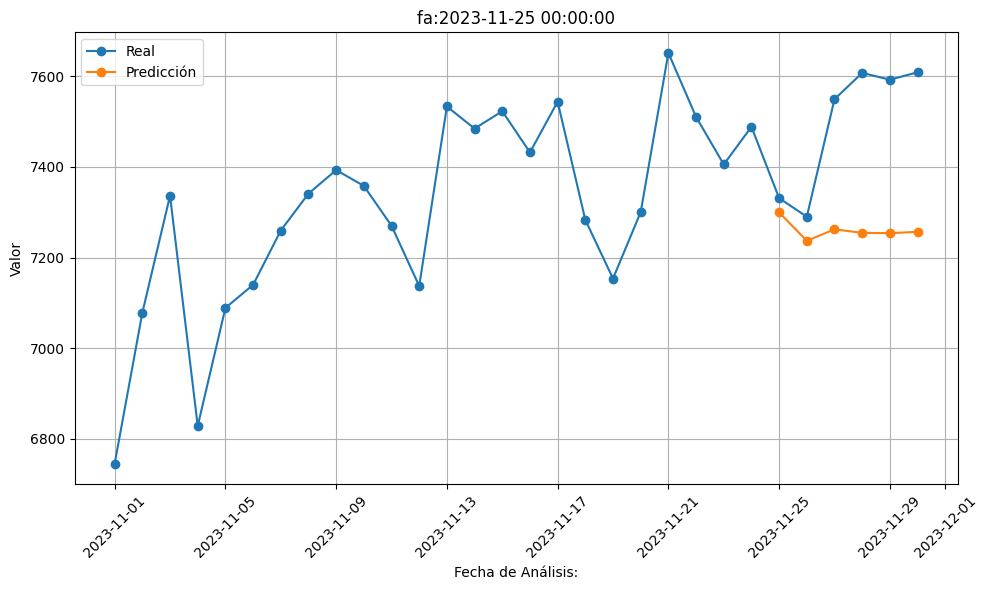

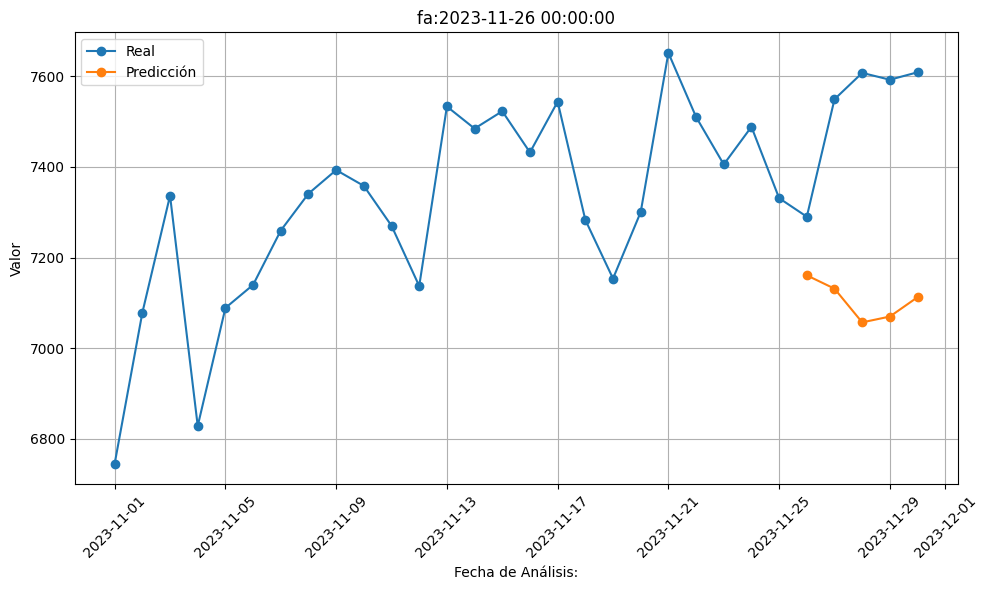

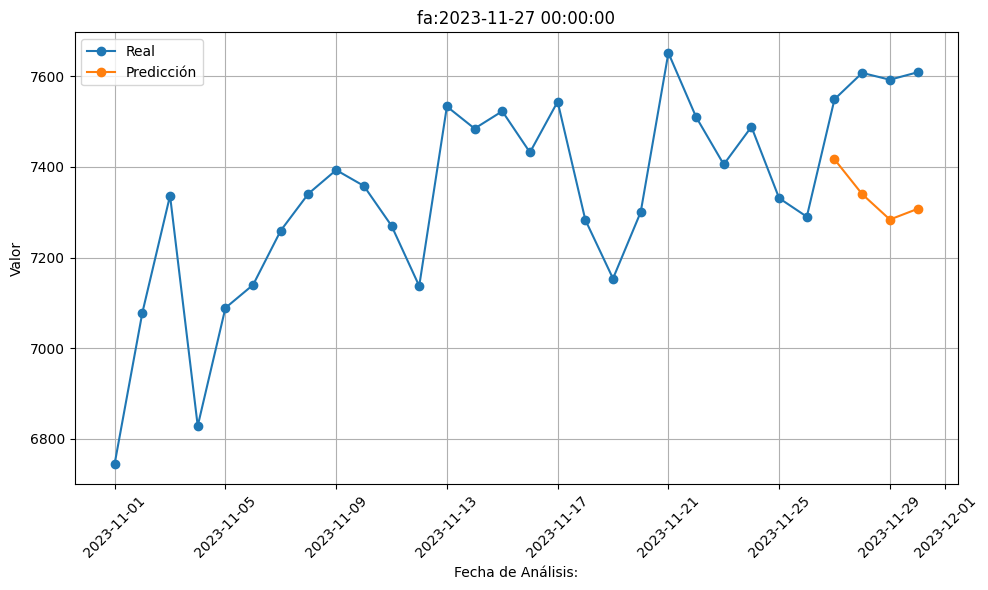

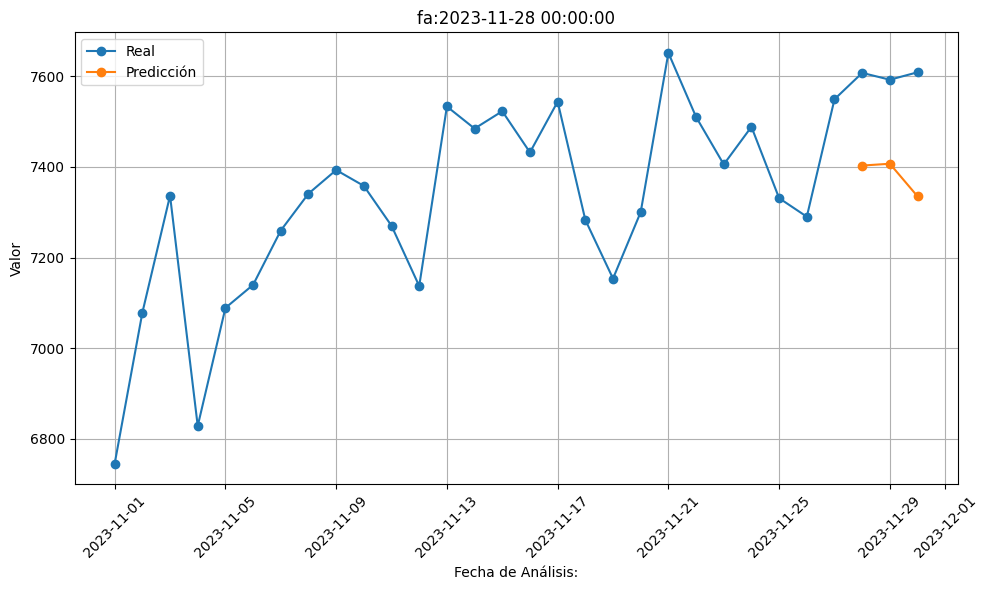

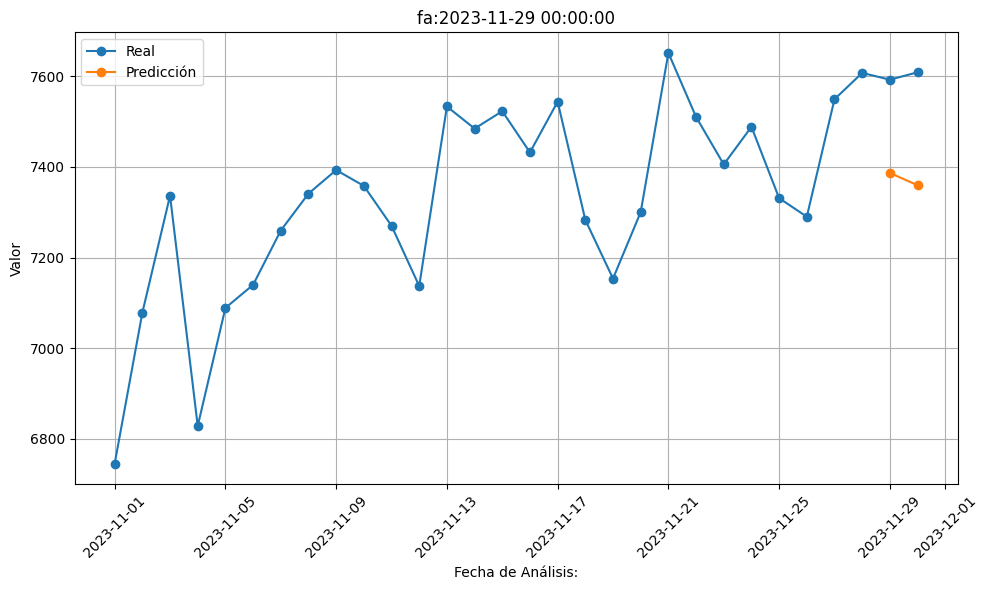

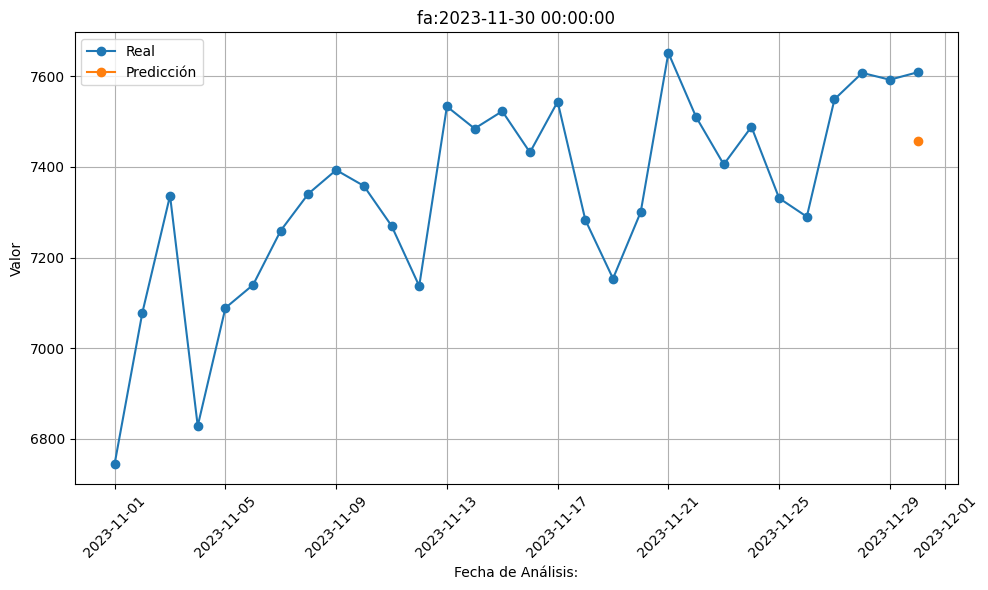

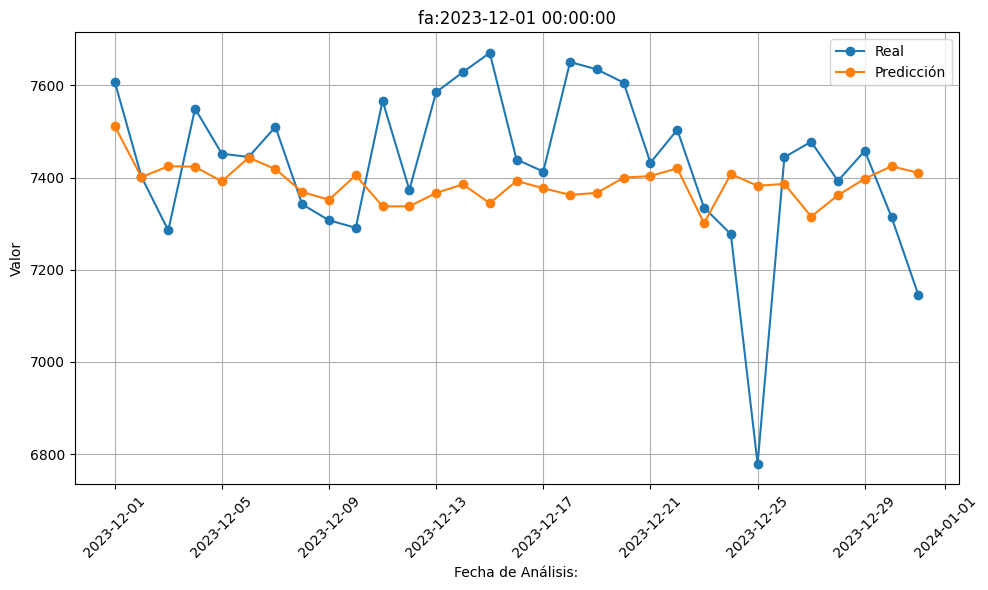

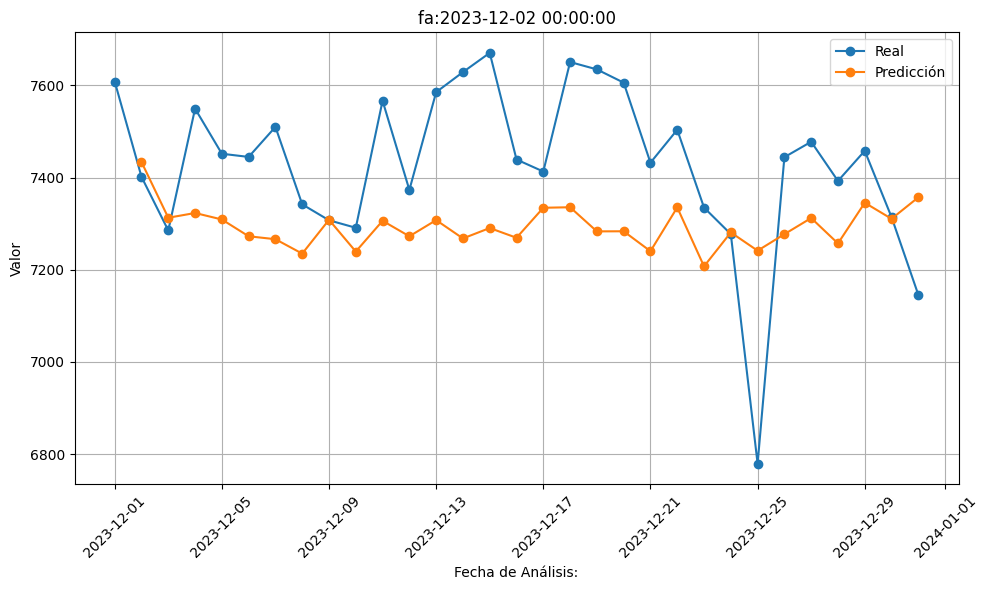

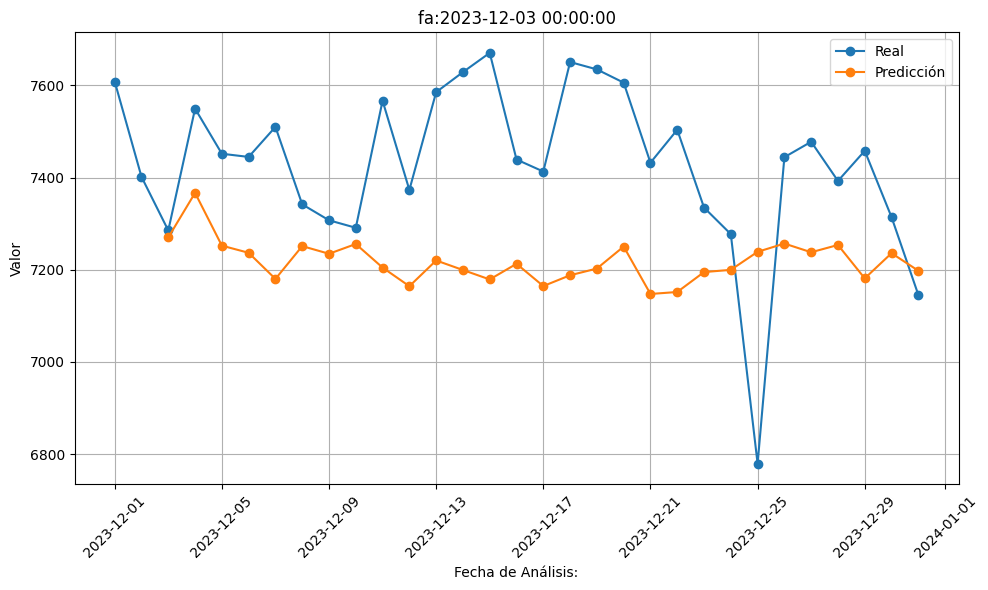

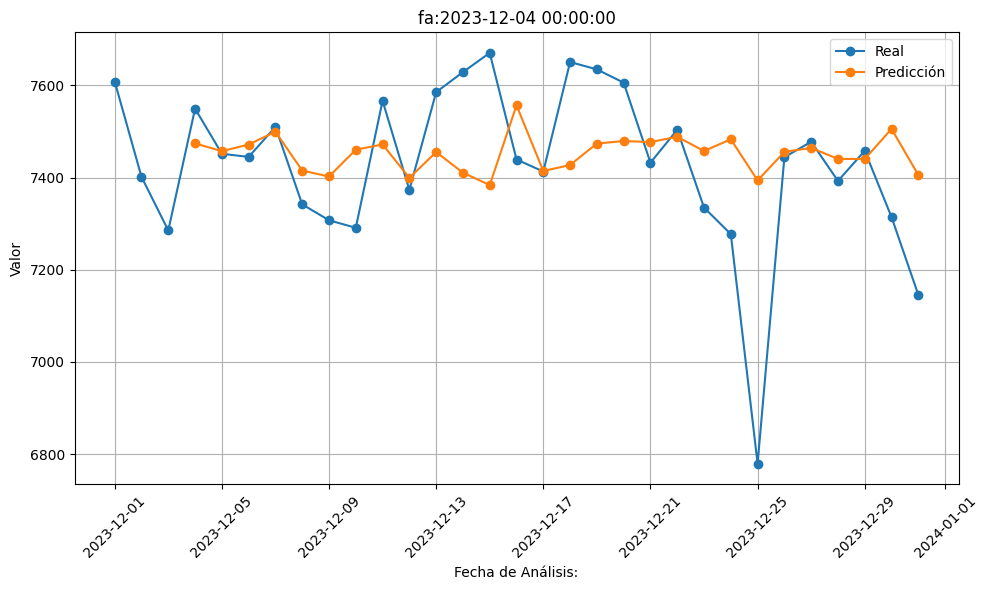

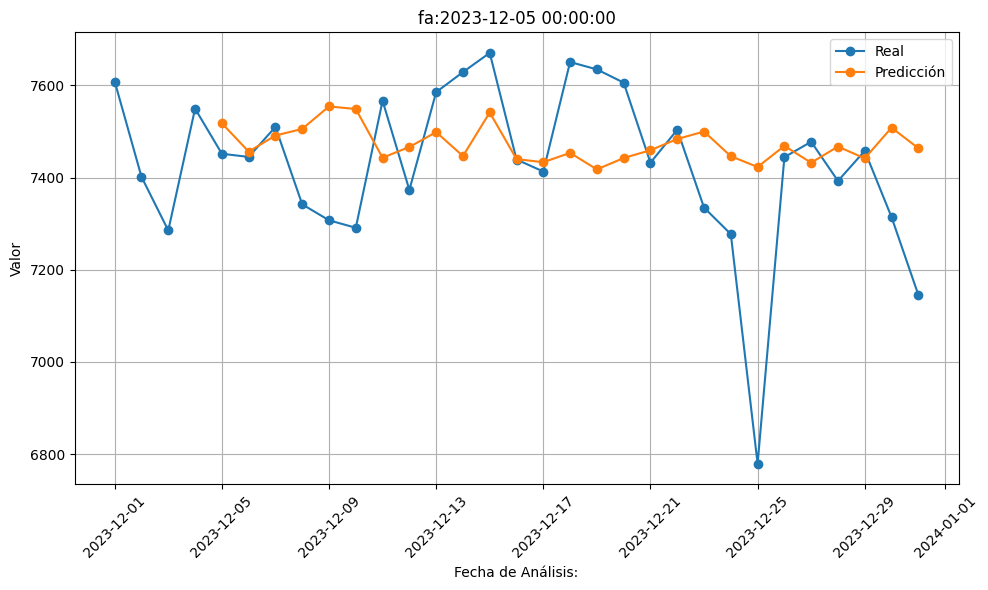

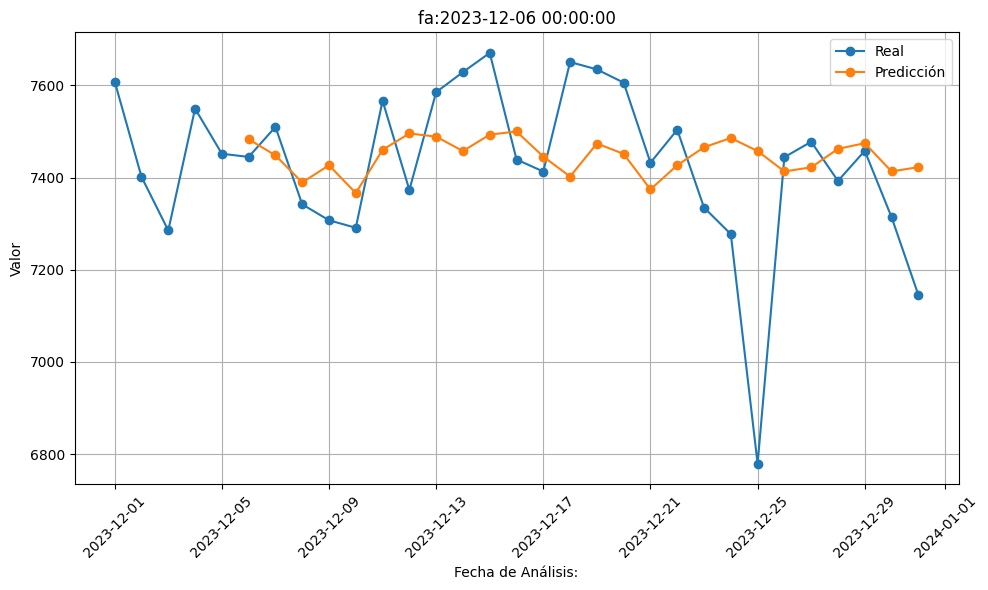

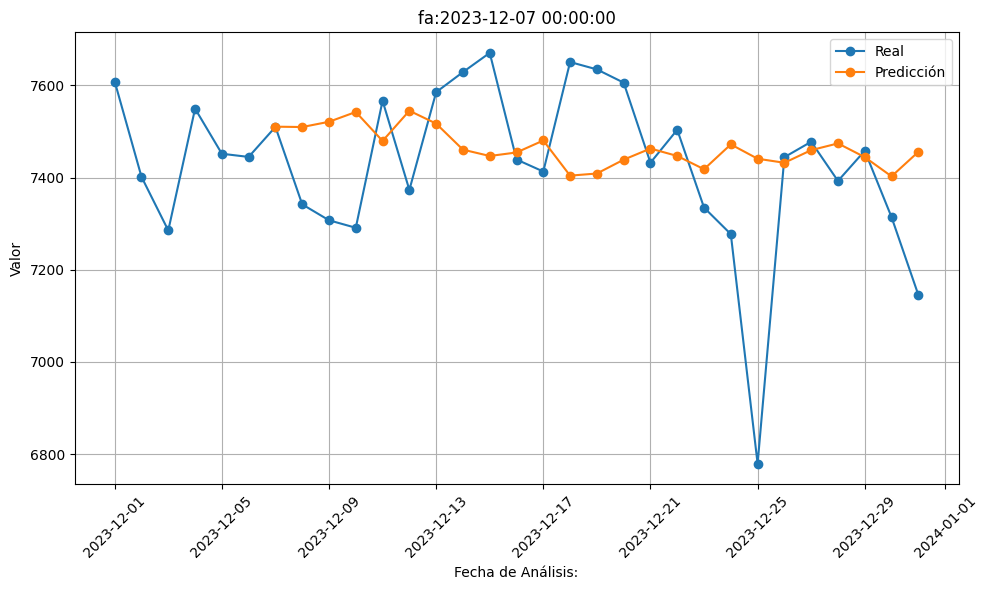

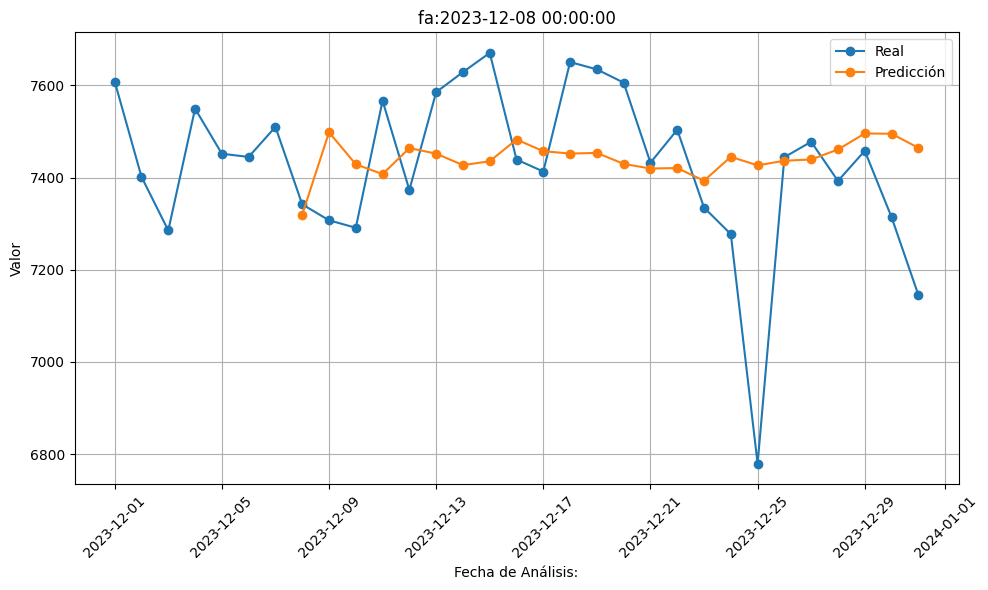

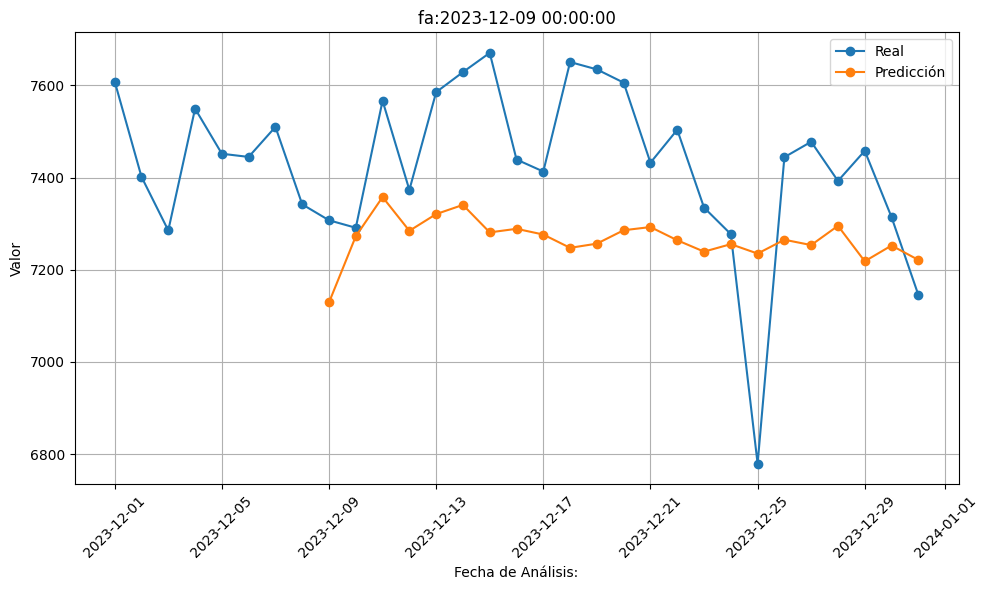

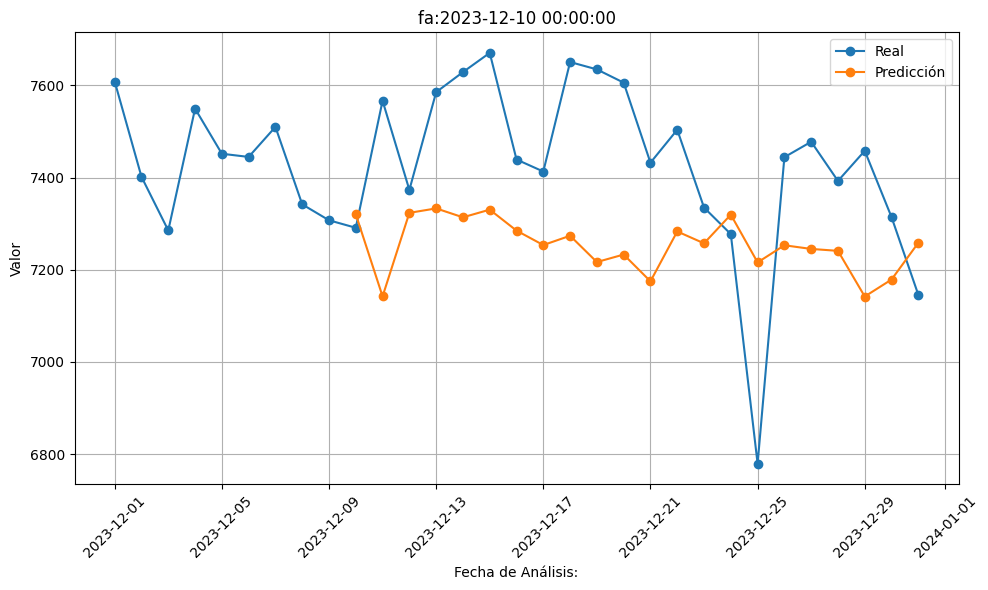

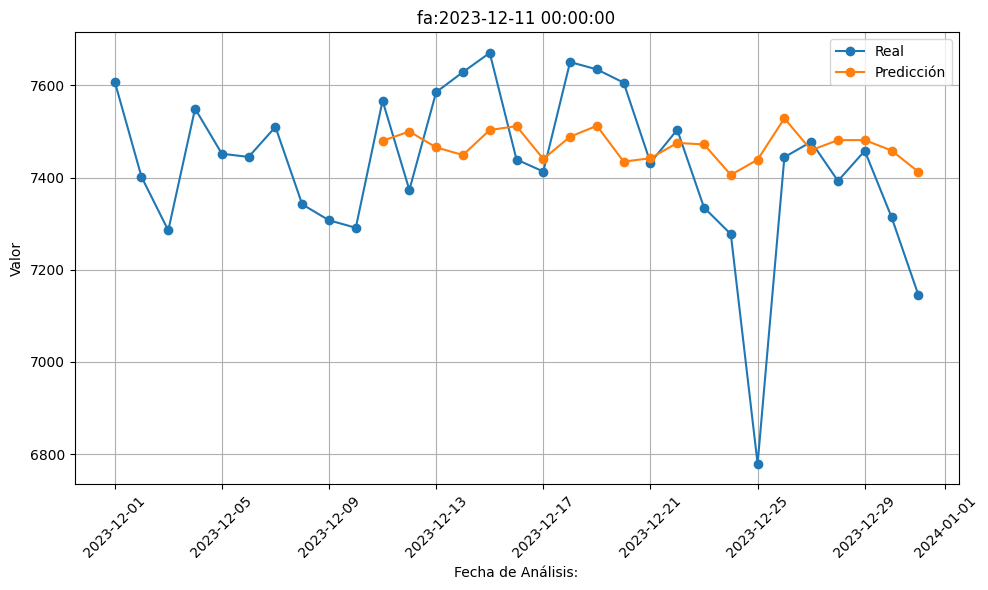

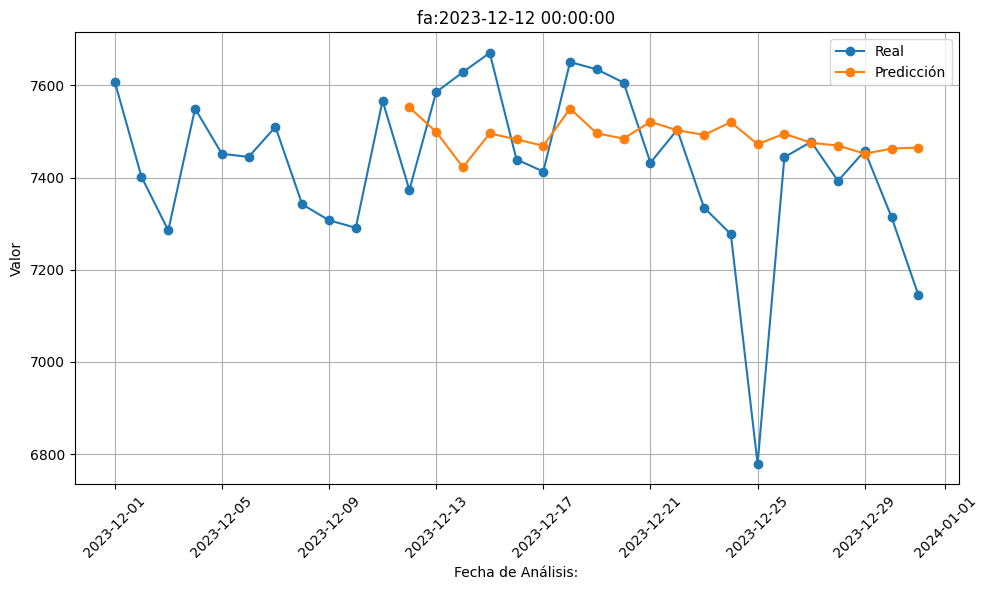

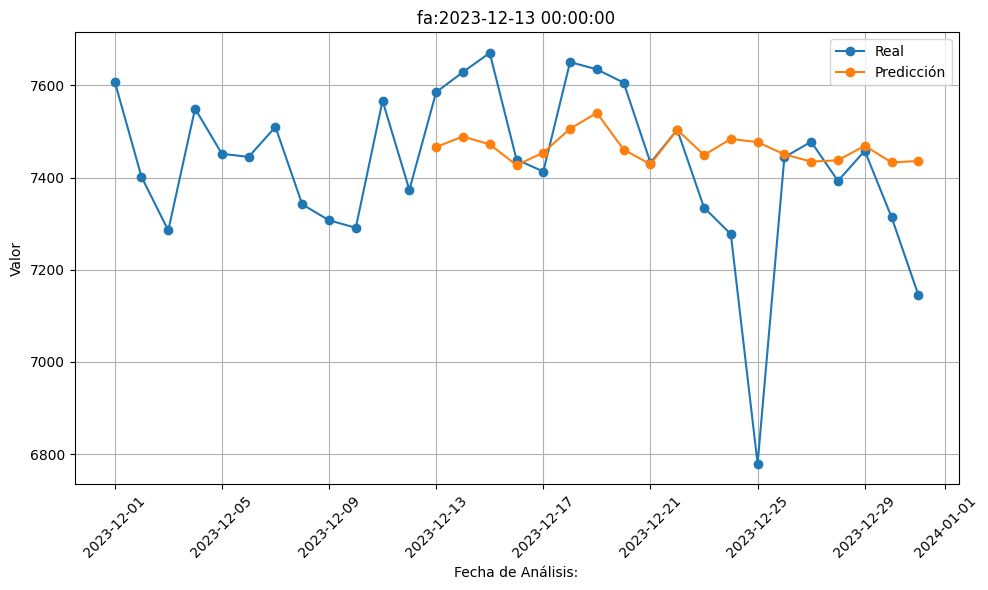

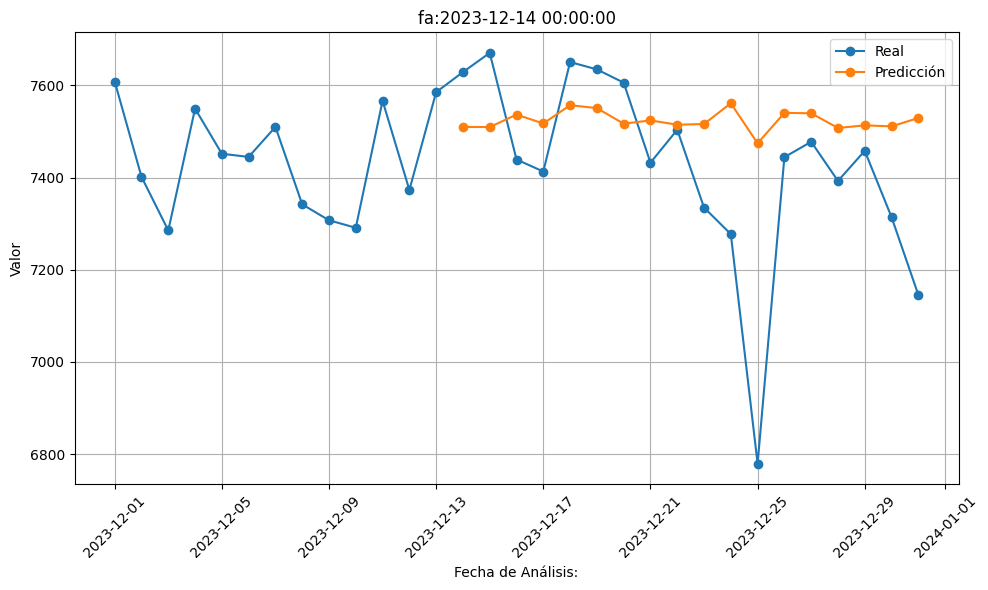

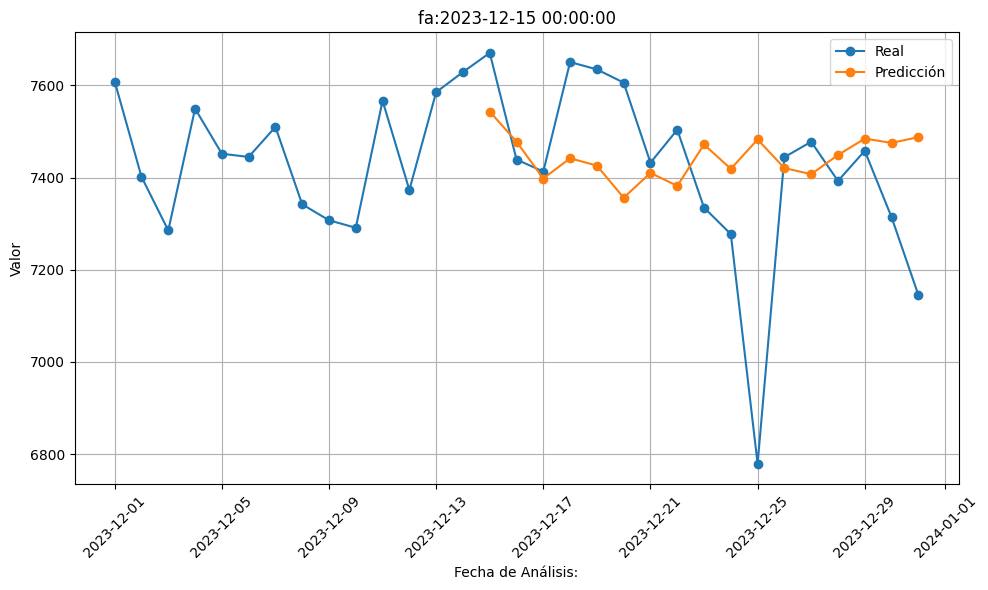

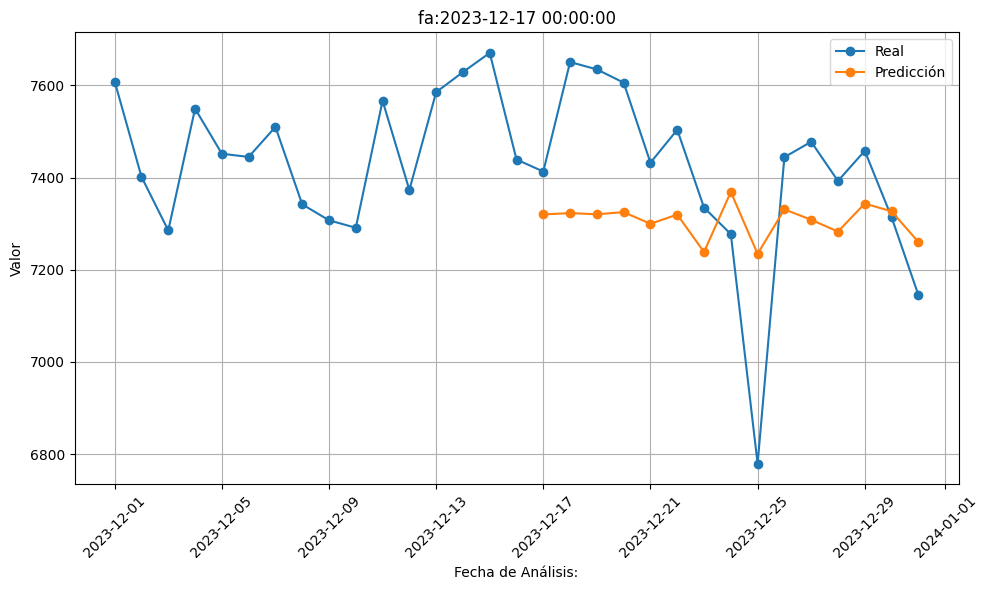

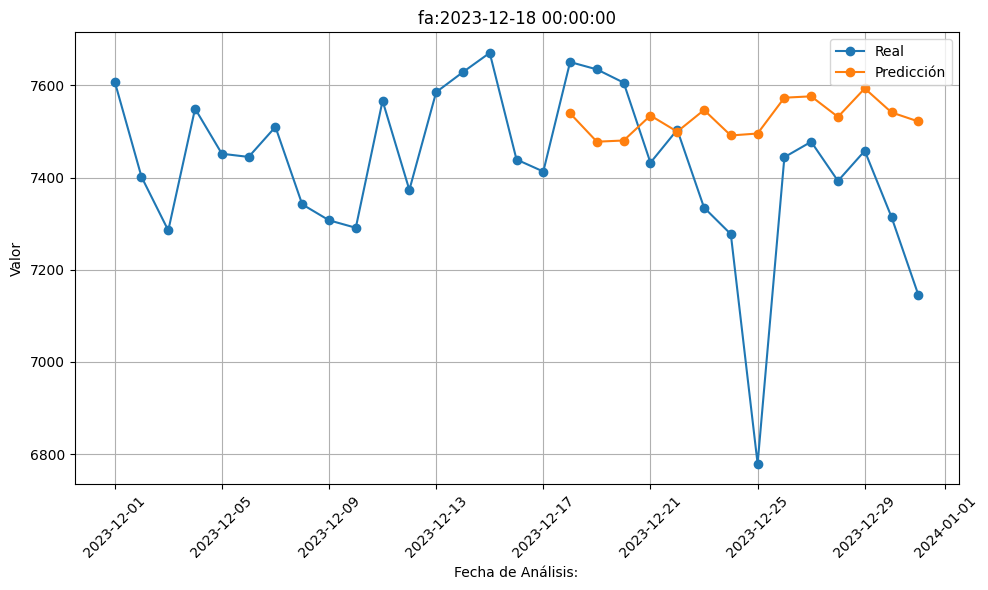

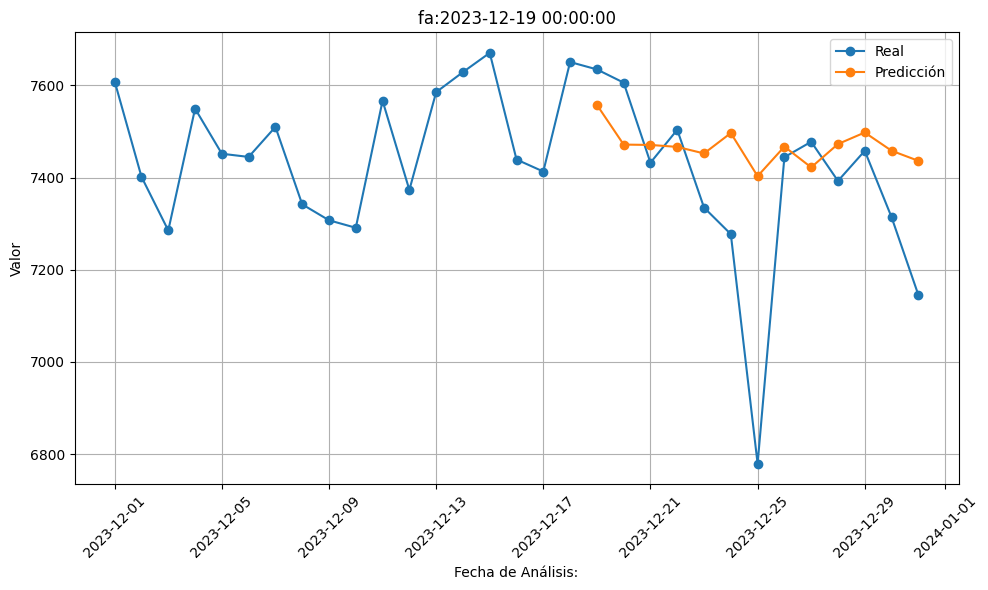

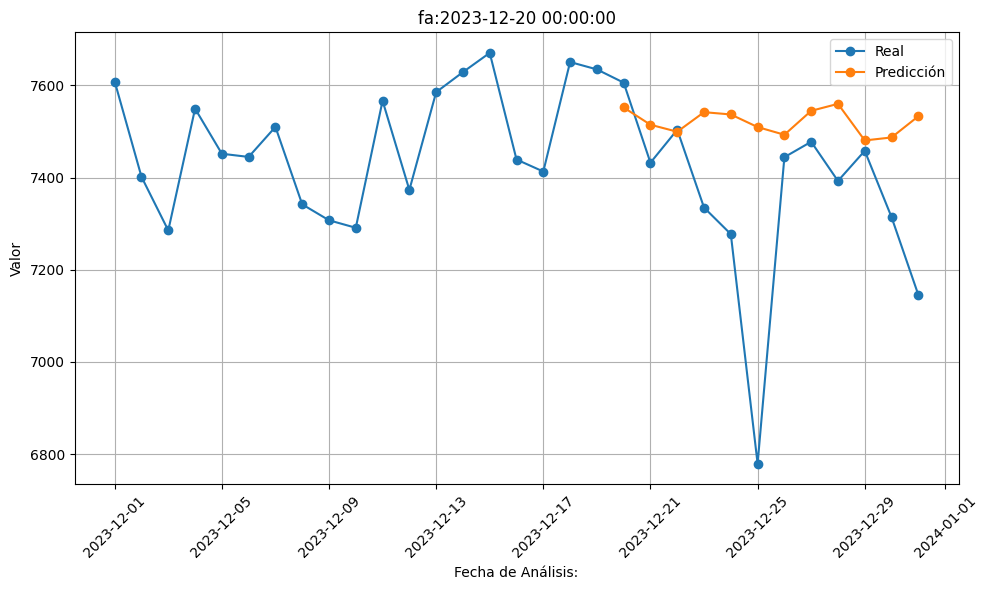

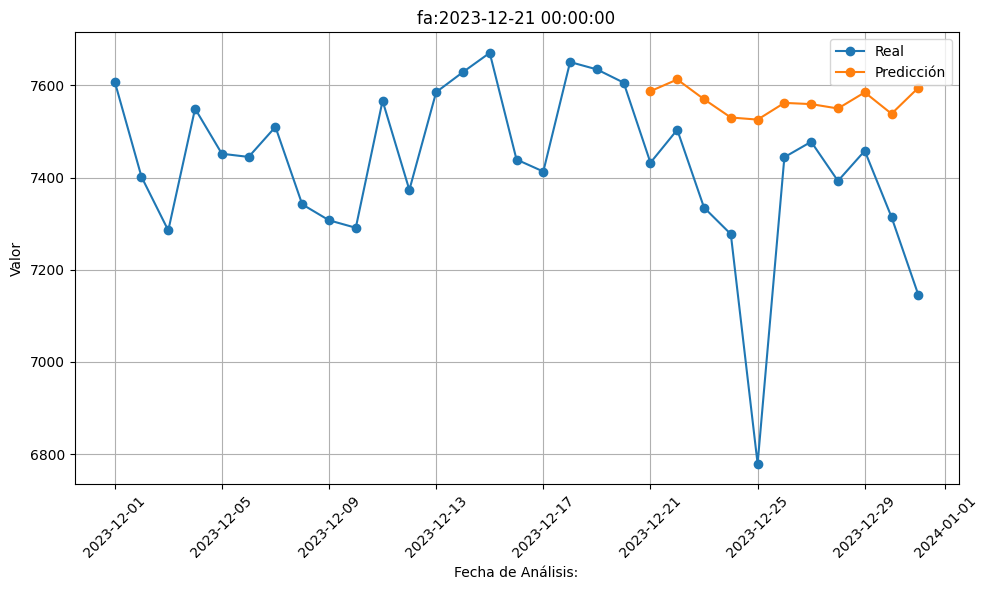

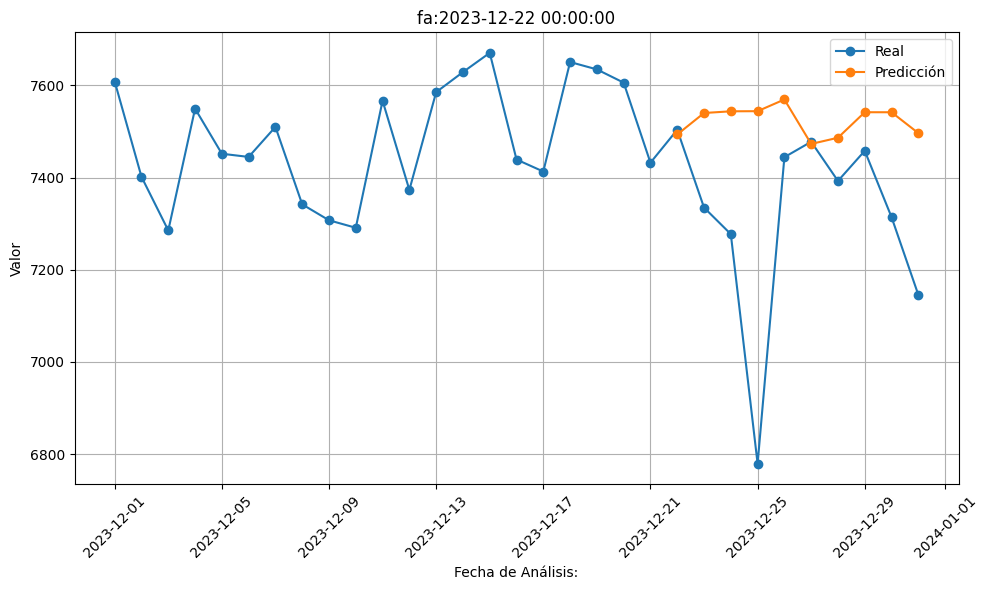

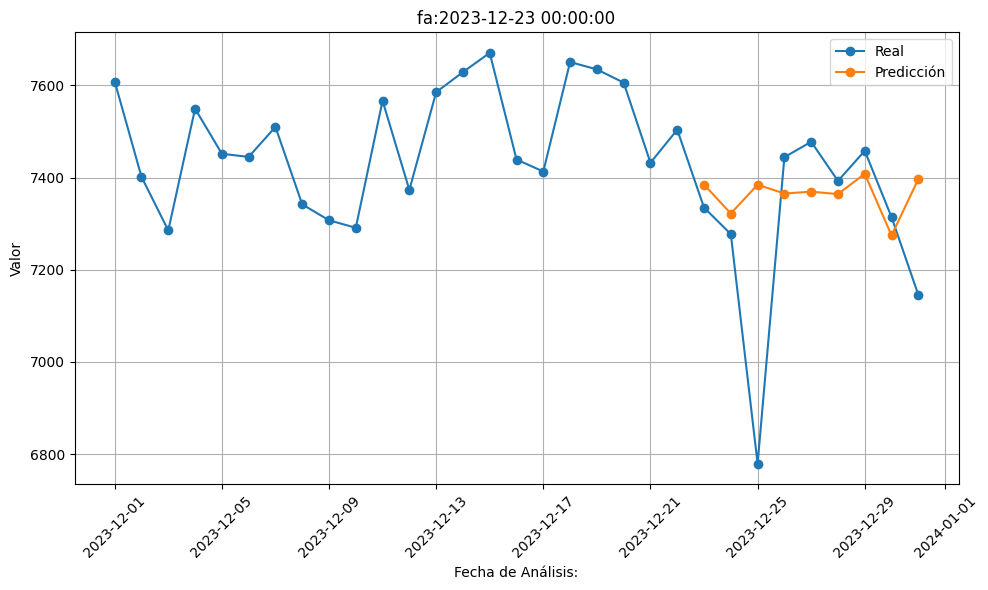

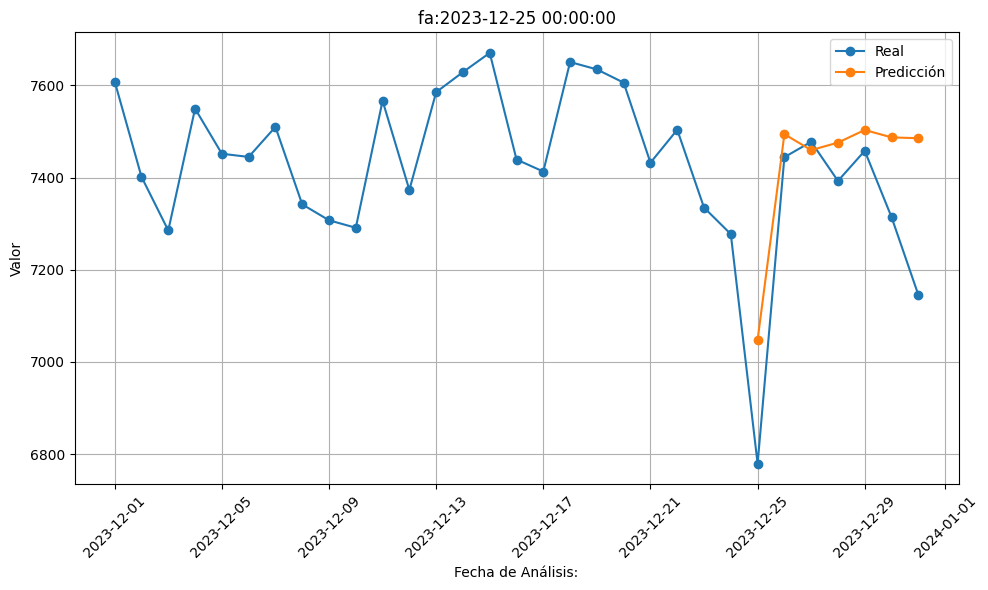

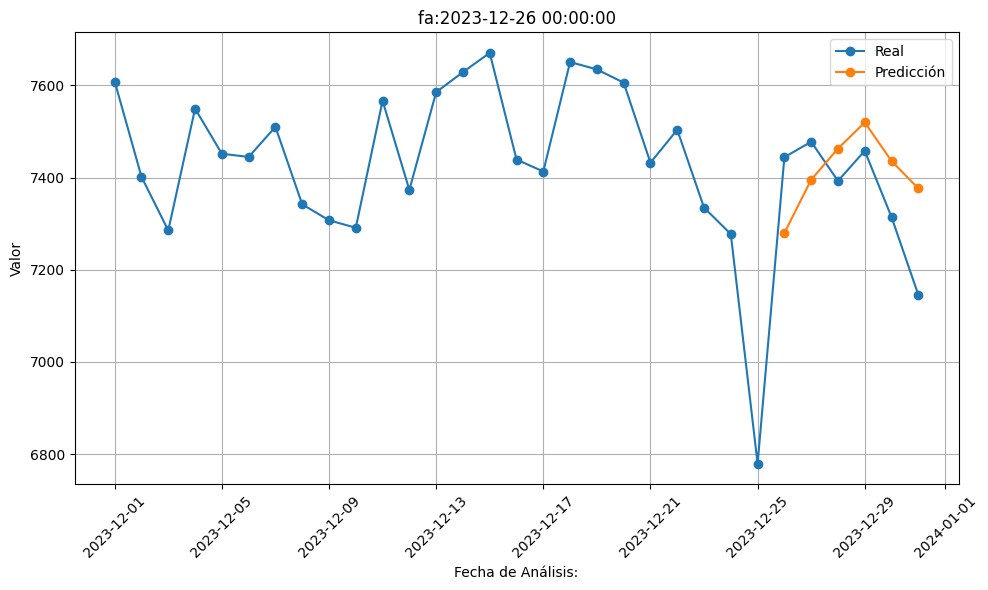

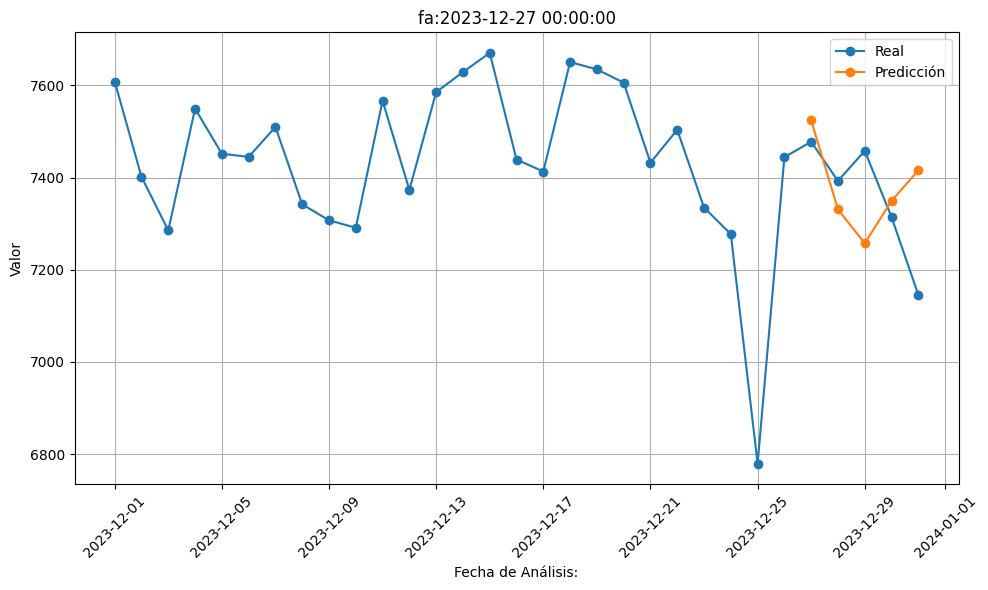

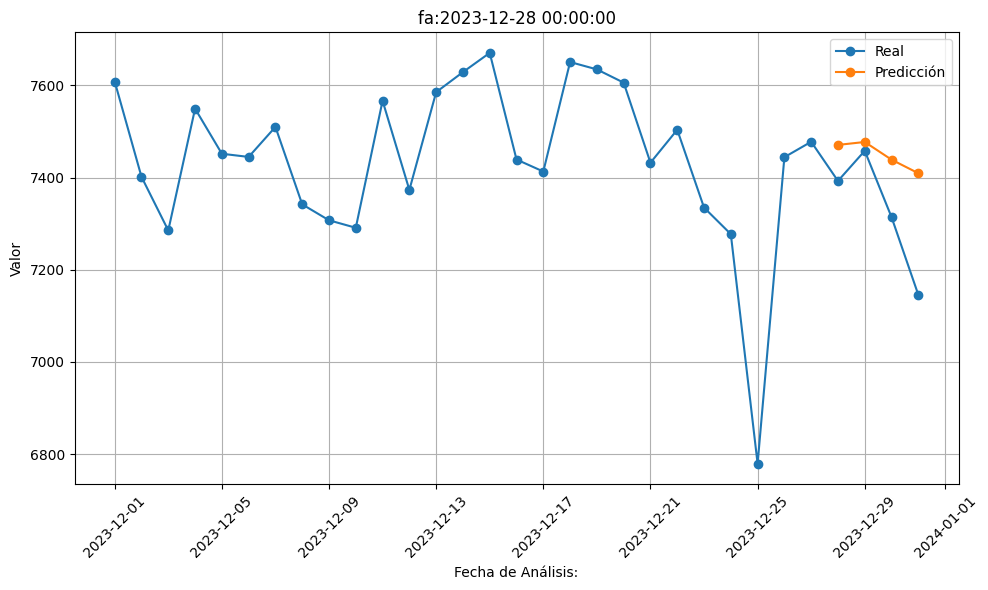

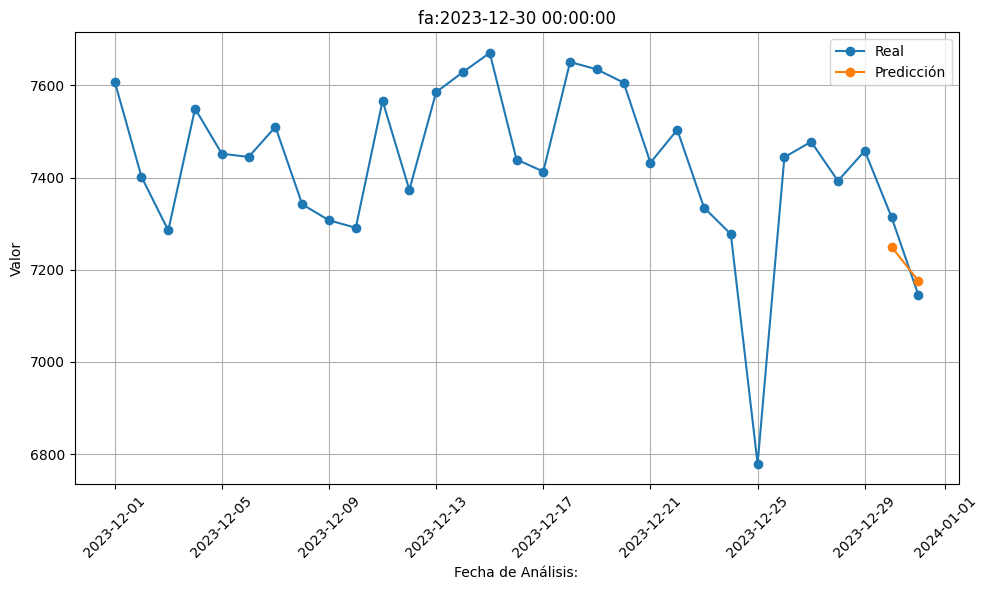

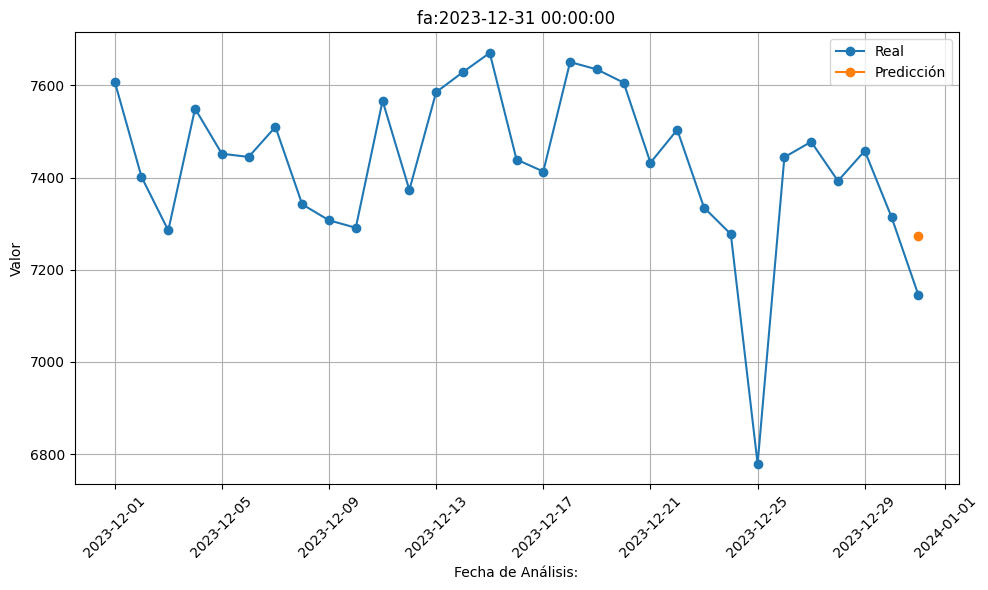

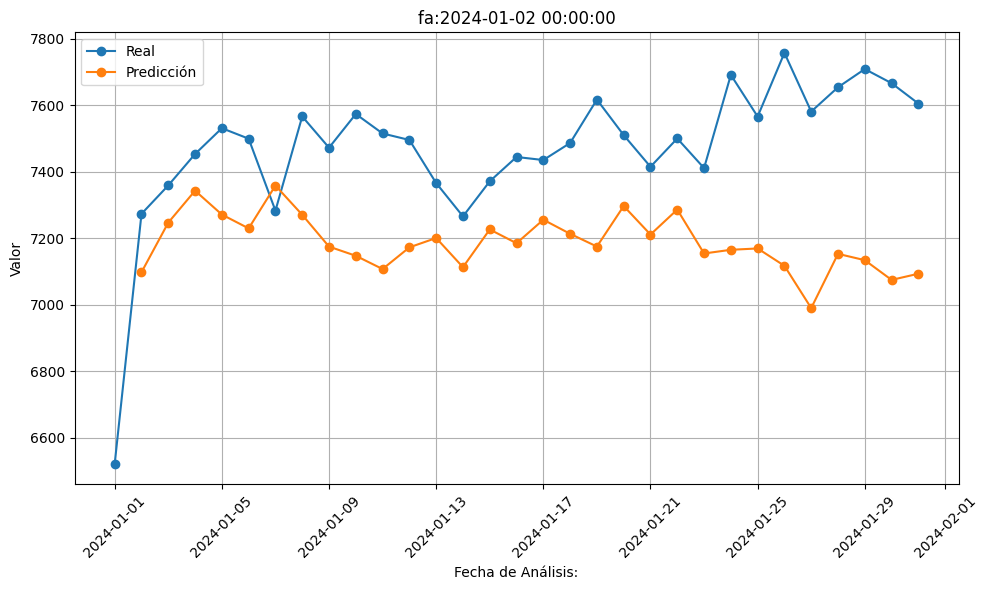

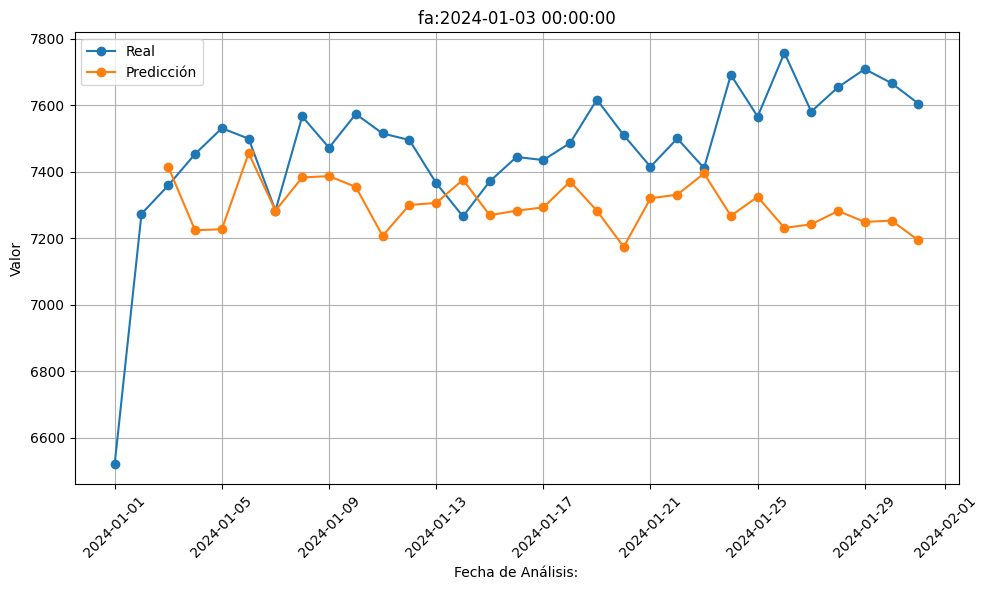

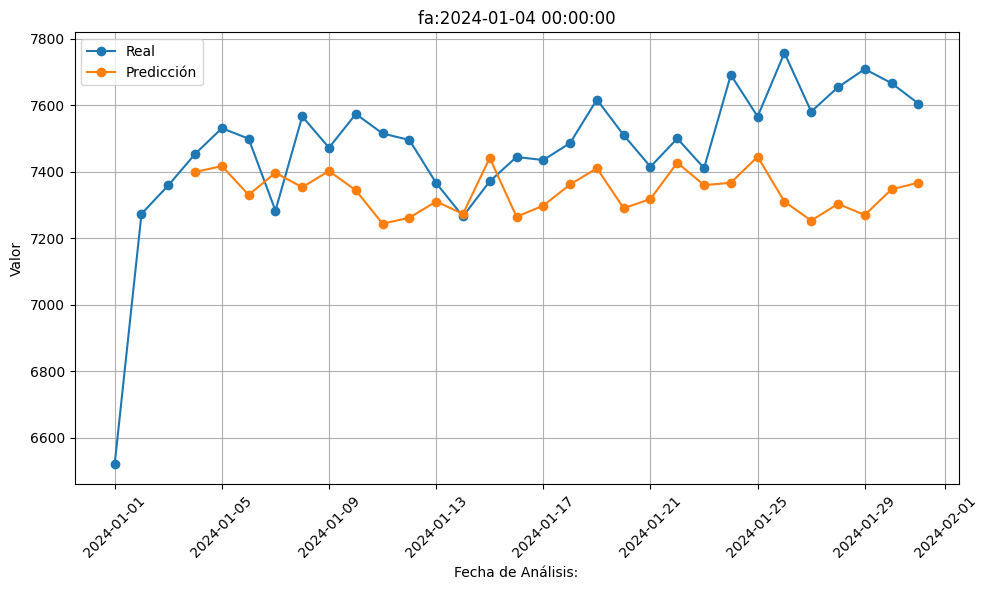

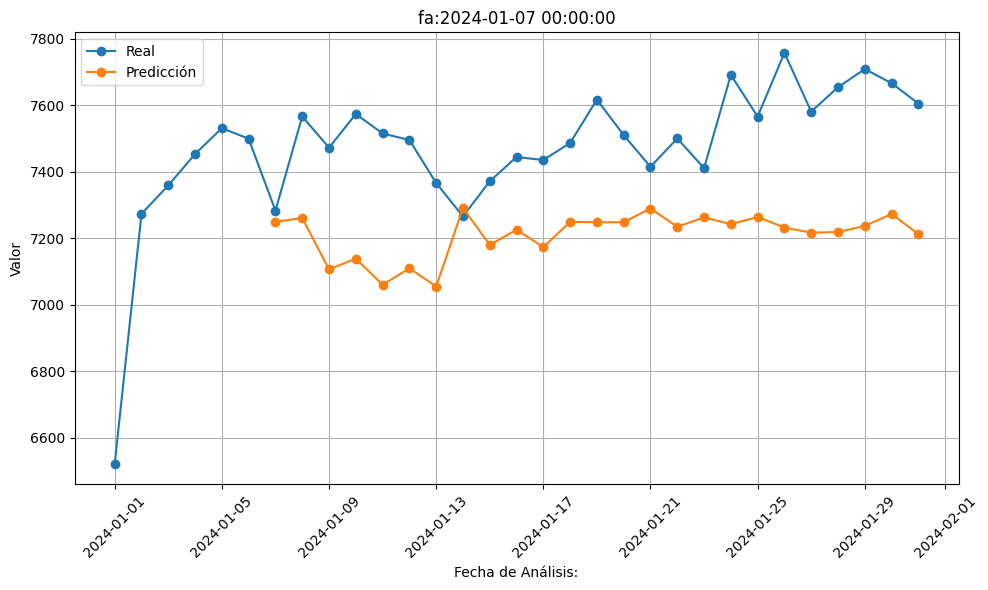

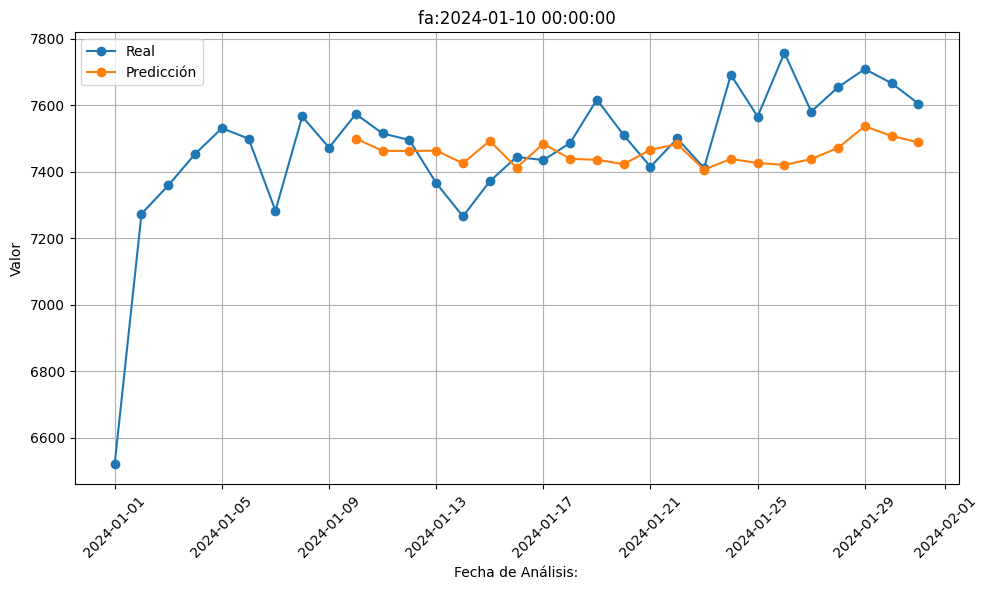

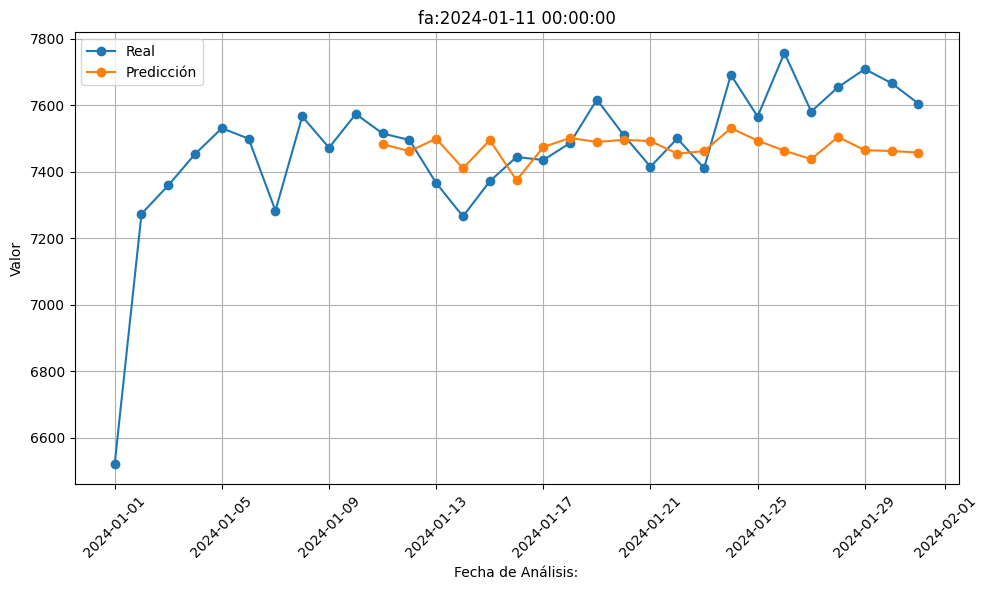

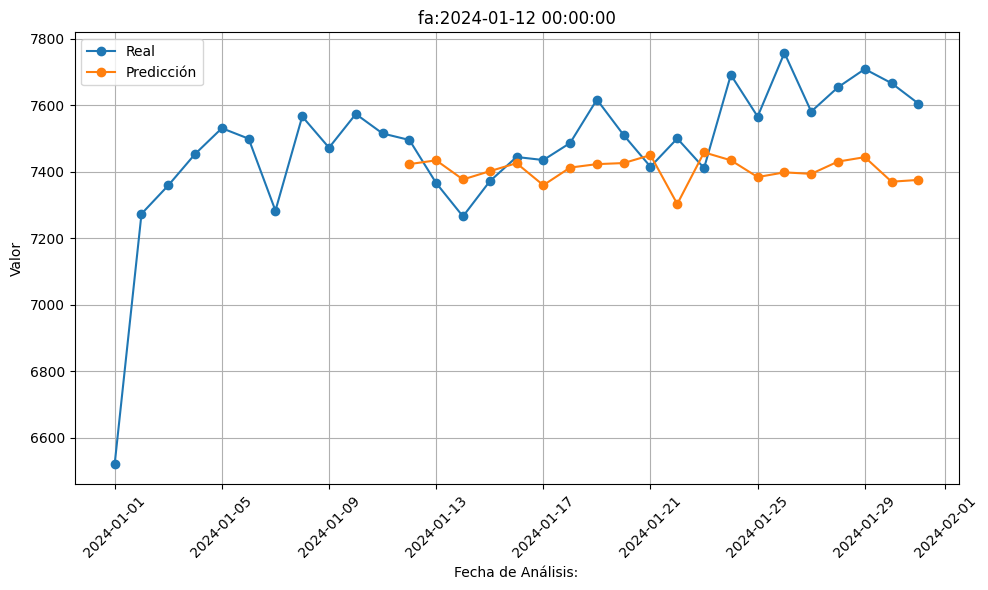

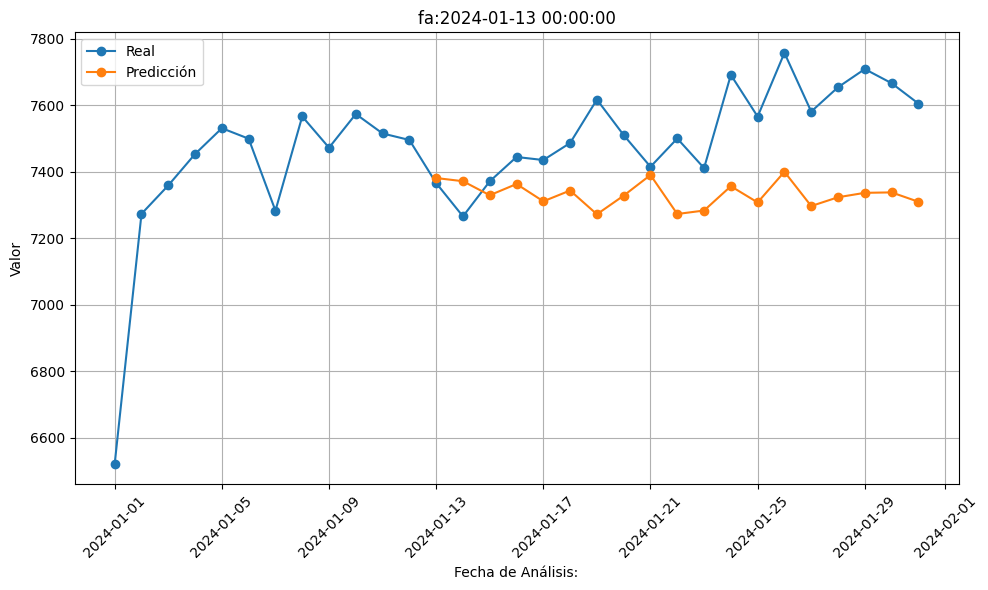

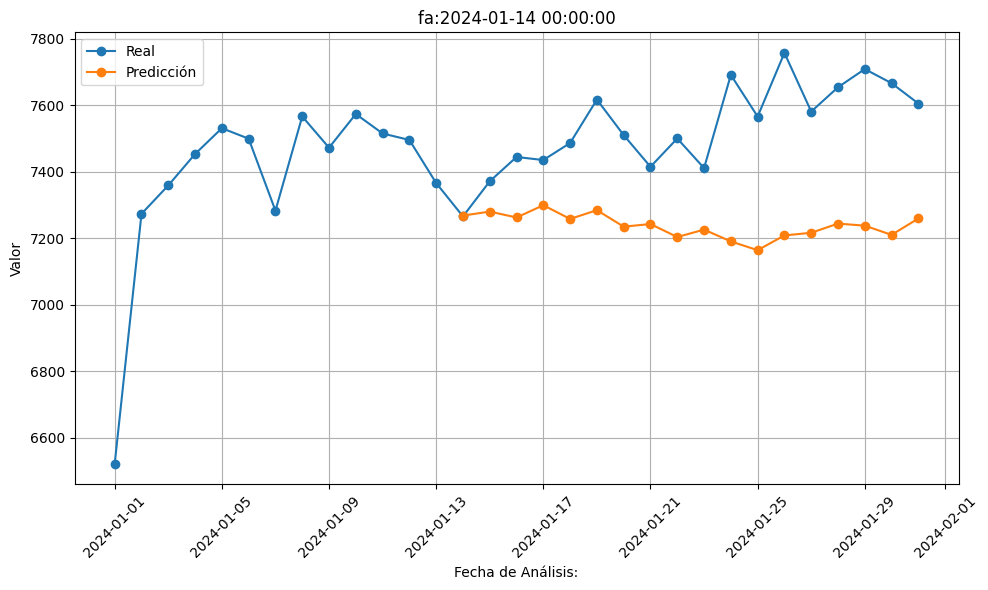

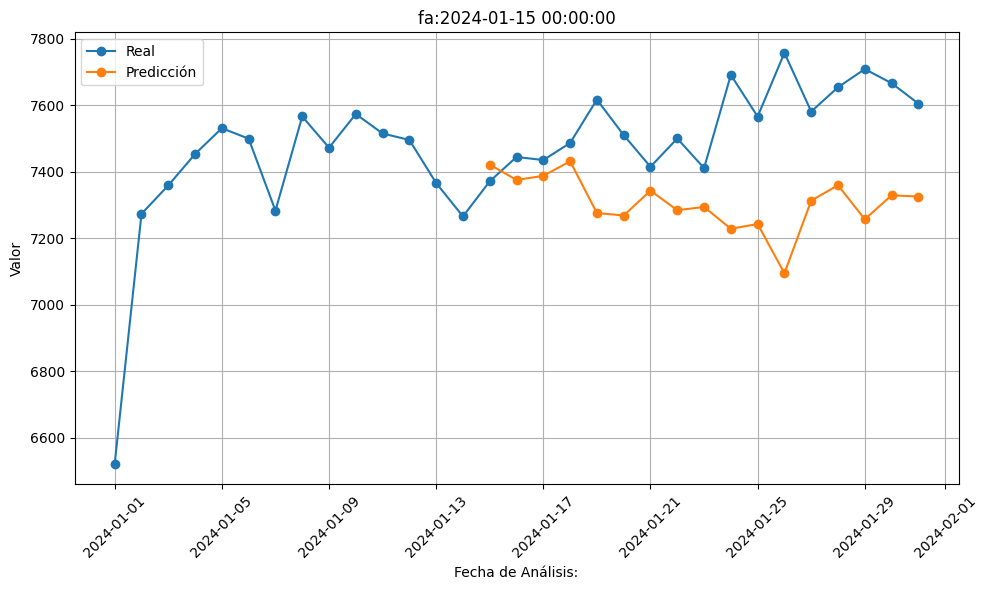

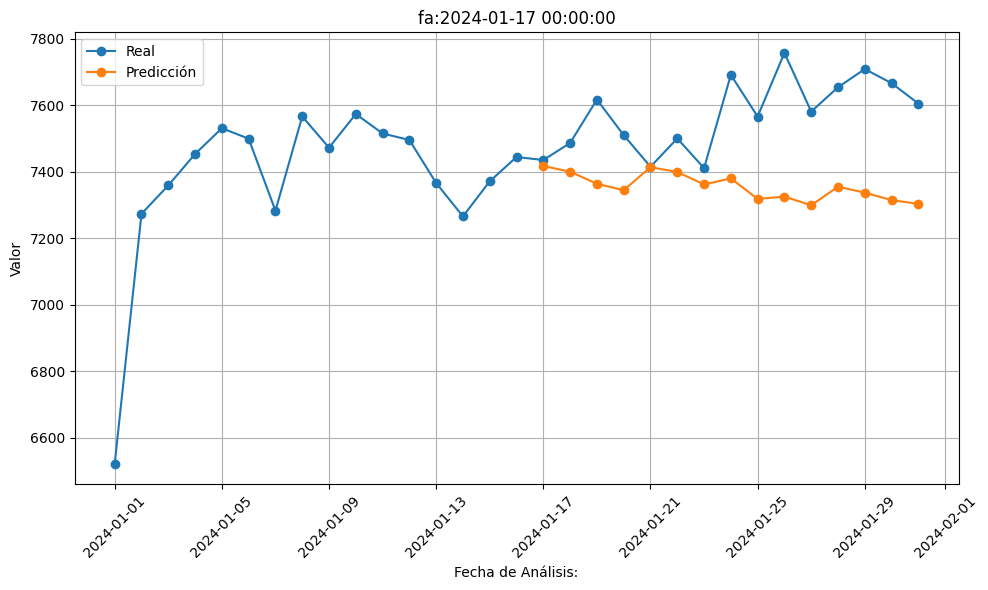

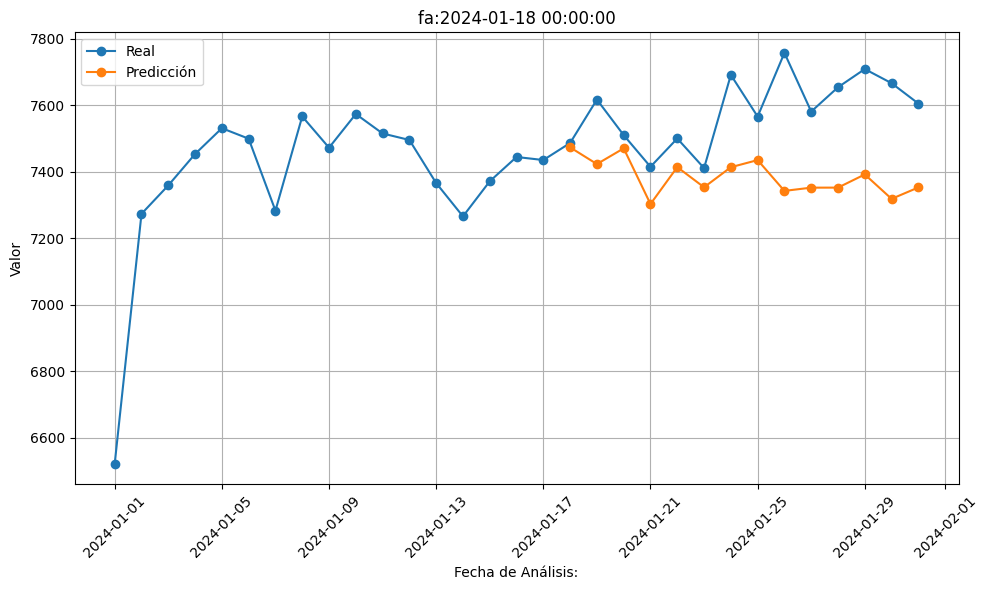

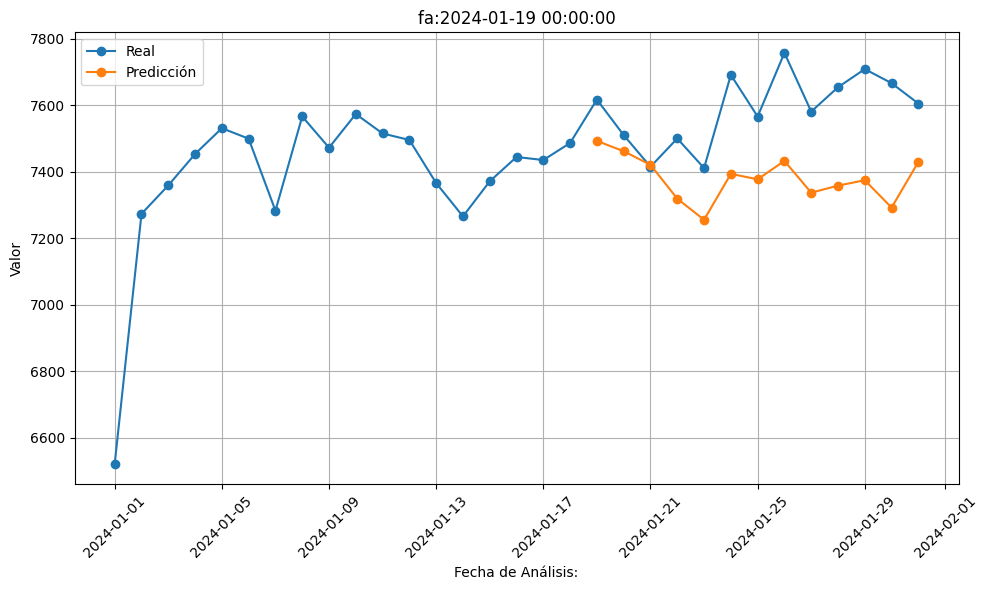

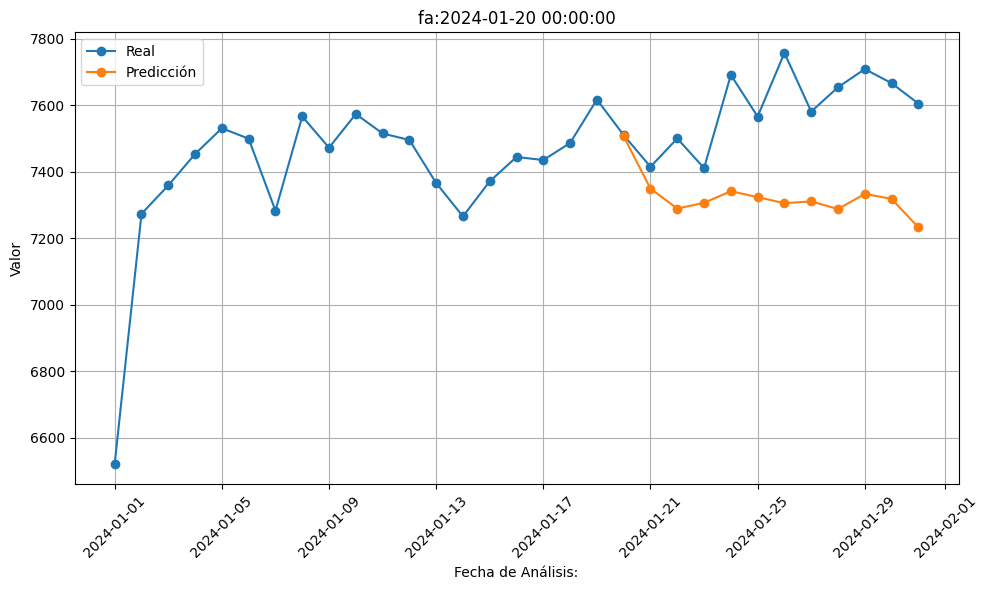

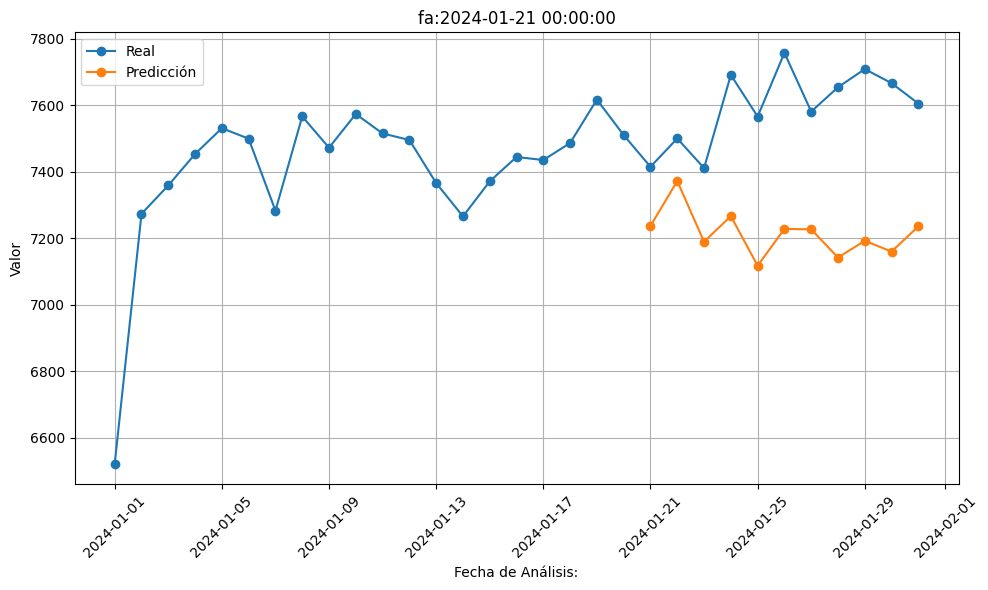

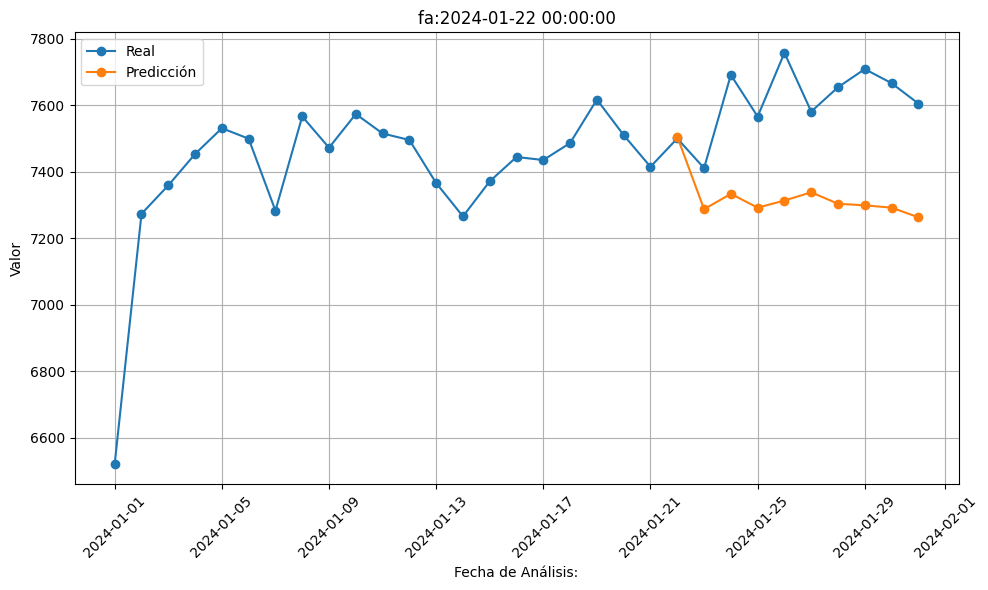

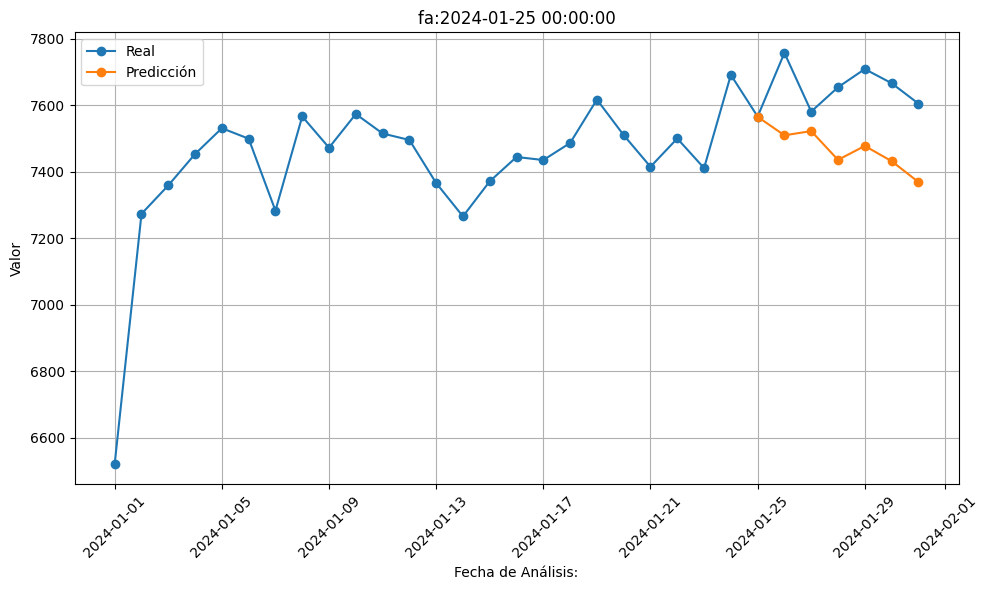

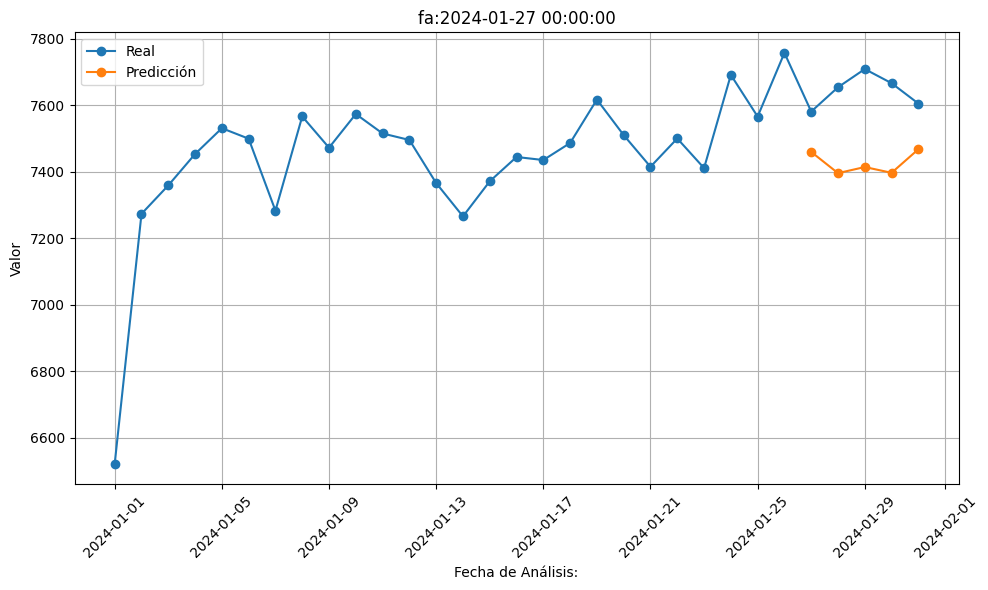

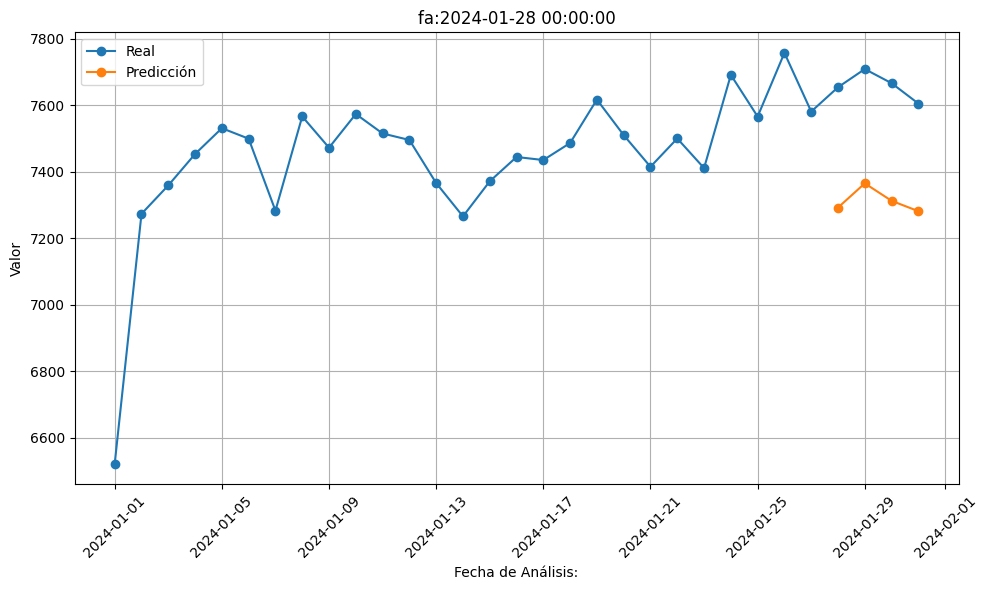

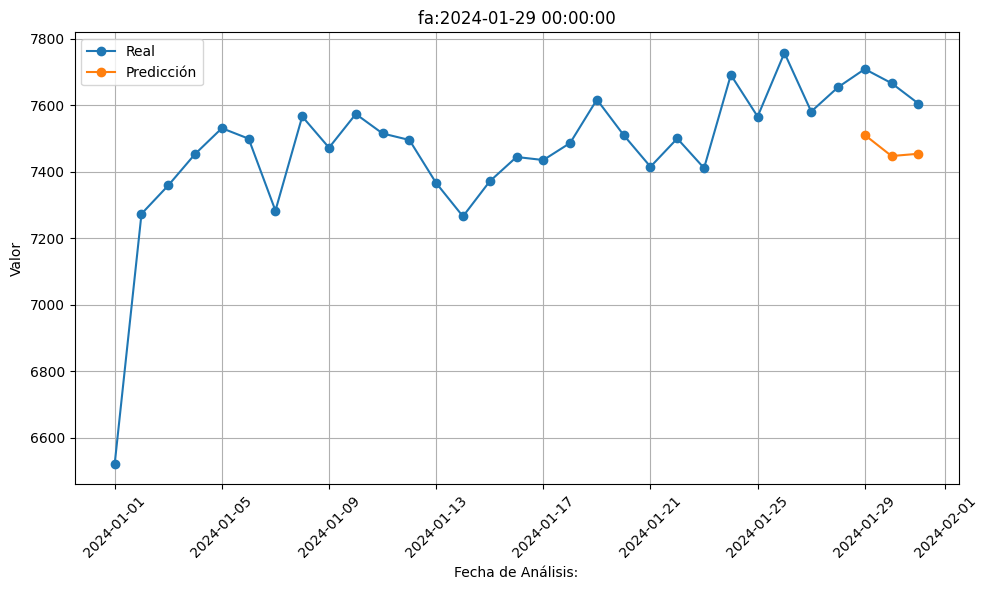

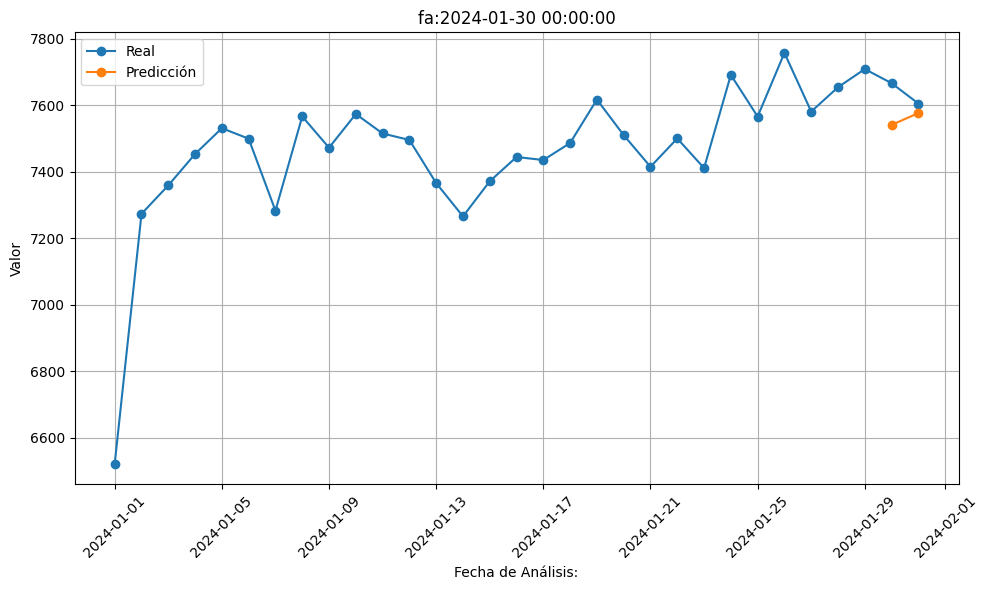

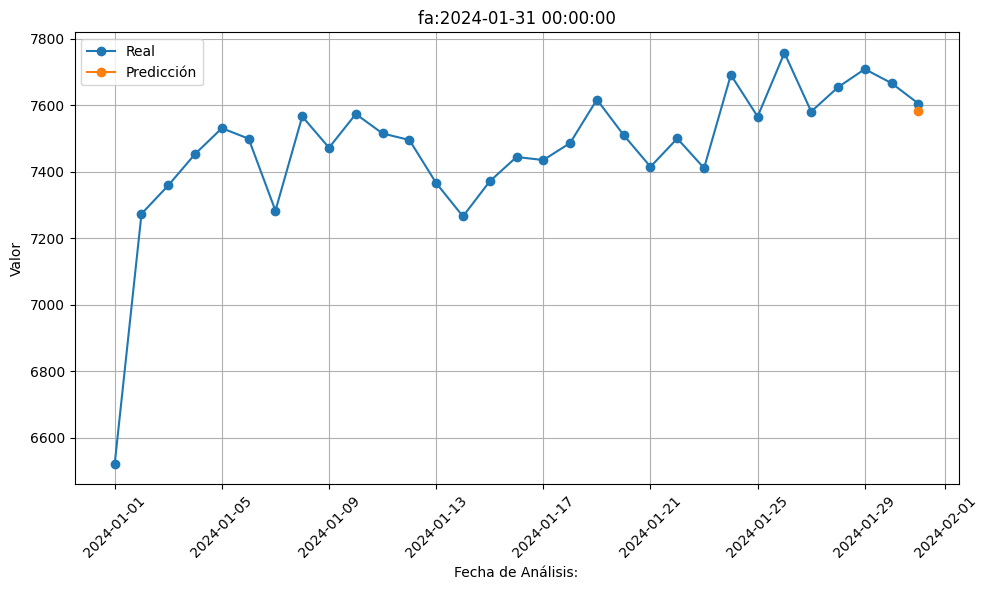

In [53]:
i = 0
for fa in dfReal['fechaAnalisis'].unique():

    df1 = dfReal[dfReal['fechaAnalisis'] == fa]
    df1 = df1[['fecha','real']]
    df2 = dfPrediccion[dfPrediccion['fechaAnalisis'] == fa]
    df2 = df2[['fecha','prediccion']]

    # Graficar
    plt.figure(figsize=(10, 6))

    # Graficar los valores reales
    plt.plot(df1['fecha'], df1['real'], marker='o', label='Real')

    # Graficar las predicciones
    plt.plot(df2['fecha'], df2['prediccion'], marker='o', label='Predicción')

    # Configurar el eje x para mostrar las fechas
    plt.xlabel('Fecha de Análisis:')
    plt.xticks(rotation=45)
    plt.grid(True)

    # Configurar el eje y y la leyenda
    plt.ylabel('Valor')
    plt.legend()

    # Mostrar la gráfica
    plt.title('fa:' + str(fa))
    plt.tight_layout()
    plt.show()
    i = i + 1
    # if (i > 4):
    #     break


In [28]:
dfFinal = dfReal.merge(dfPrediccion, on=['fechaAnalisis','fecha'], how='left')
dfFinal['seriePrediccion'] = 0
dfFinal['seriePrediccion']= dfFinal['seriePrediccion'].mask(dfFinal['prediccion'].notnull(), dfFinal['prediccion']).mask(dfFinal['prediccion'].isnull(), dfFinal['real'])
dfFinal

fechaAnalisis      fecha        real   prediccion  seriePrediccion
0       2023-11-01 2023-11-01  6745.48976  6874.529297      6874.529297
1       2023-11-01 2023-11-02  7078.55867  7099.926758      7099.926758
2       2023-11-01 2023-11-03  7336.75801  7213.427246      7213.427246
3       2023-11-01 2023-11-04  6828.55927  7240.506348      7240.506348
4       2023-11-01 2023-11-05  7089.00557  7276.633789      7276.633789
...            ...        ...         ...          ...              ...
4619    2024-03-31 2024-03-27  7623.37861          NaN      7623.378610
4620    2024-03-31 2024-03-28  7384.08005          NaN      7384.080050
4621    2024-03-31 2024-03-29  7138.48225          NaN      7138.482250
4622    2024-03-31 2024-03-30  7262.40741          NaN      7262.407410
4623    2024-03-31 2024-03-31  7223.41316  7263.874512      7263.874512

[4624 rows x 5 columns]

In [29]:
# obtenemos los picos predichos (maximo de seriePrediccion)
dfPicosPredichos = dfFinal.groupby('fechaAnalisis')['seriePrediccion'].idxmax()
dfPicosPredichos = dfFinal.loc[dfPicosPredichos]
dfPicosPredichos = dfPicosPredichos.rename(columns={'seriePrediccion': 'valorPicoPredicho', 'fecha': 'fechaPicoPredicho'})

listaCortes = [0.01, 0.01216, 0.01432, 0.01648,  0.0165664, 0.0166528, 0.0167392, 0.0168256,      0.016912, 0.017344, 0.017776, 0.018208,  0.01864, 0.0208, 0.022744, 0.024688, 0.026632, 0.028576, 0.03052, 0.03304, 0.03556, 0.03808, 0.0406, 0.0604, 0.0802, 0.1] 
dfCortes = pd.DataFrame(listaCortes, columns=['corte'])
dfPicosPredichos = dfPicosPredichos.merge(dfCortes, how='cross')
dfPicosPredichos['picoSegunCorte'] = (1-dfPicosPredichos['corte'])*dfPicosPredichos['valorPicoPredicho']
dfPicosPredichos = dfPicosPredichos[['fechaAnalisis','corte','picoSegunCorte']]
dfPicosPredichos.head()

fechaAnalisis     corte  picoSegunCorte
0    2023-11-01  0.010000     7247.078438
1    2023-11-01  0.012160     7231.266630
2    2023-11-01  0.014320     7215.454822
3    2023-11-01  0.016480     7199.643015
4    2023-11-01  0.016566     7199.010543

In [30]:
dfFinal.head()

fechaAnalisis      fecha        real   prediccion  seriePrediccion
0    2023-11-01 2023-11-01  6745.48976  6874.529297      6874.529297
1    2023-11-01 2023-11-02  7078.55867  7099.926758      7099.926758
2    2023-11-01 2023-11-03  7336.75801  7213.427246      7213.427246
3    2023-11-01 2023-11-04  6828.55927  7240.506348      7240.506348
4    2023-11-01 2023-11-05  7089.00557  7276.633789      7276.633789

In [31]:
dfFinal = dfFinal[dfFinal['fechaAnalisis']==dfFinal['fecha']]
dfFinal = dfFinal.merge(dfPicosPredichos, on='fechaAnalisis', how='inner')
dfFinal['picoPredicho'] = (dfFinal['seriePrediccion'] >= dfFinal['picoSegunCorte'])
dfFinal['mes'] = dfFinal['fechaAnalisis'].dt.strftime('%Y%m')
dfFinal

fechaAnalisis      fecha        real   prediccion  seriePrediccion  \
0       2023-11-01 2023-11-01  6745.48976  6874.529297      6874.529297   
1       2023-11-01 2023-11-01  6745.48976  6874.529297      6874.529297   
2       2023-11-01 2023-11-01  6745.48976  6874.529297      6874.529297   
3       2023-11-01 2023-11-01  6745.48976  6874.529297      6874.529297   
4       2023-11-01 2023-11-01  6745.48976  6874.529297      6874.529297   
...            ...        ...         ...          ...              ...   
3947    2024-03-31 2024-03-31  7223.41316  7263.874512      7263.874512   
3948    2024-03-31 2024-03-31  7223.41316  7263.874512      7263.874512   
3949    2024-03-31 2024-03-31  7223.41316  7263.874512      7263.874512   
3950    2024-03-31 2024-03-31  7223.41316  7263.874512      7263.874512   
3951    2024-03-31 2024-03-31  7223.41316  7263.874512      7263.874512   

         corte  picoSegunCorte  picoPredicho     mes  
0     0.010000     7247.078438         False  202311  
1     0.012160     7231.266630         False  202311  
2     0.014320     7215.454822         False  202311  
3     0.016480     7199.643015         False  202311  
4     0.016566     7199.010543         False  202311  
...        ...             ...           ...     ...  
3947  0.038080     7404.395360         False  202403  
3948  0.040600     7384.997618         False  202403  
3949  0.060400     7232.586785          True  202403  
3950  0.080200     7080.175953          True  202403  
3951  0.100000     6927.765120          True  202403  

[3952 rows x 9 columns]

In [32]:
# Agrupar los datos por año y mes, y calcular el máximo valor de 'EJECUTADO' para cada grupo
dfTP = dfCOES.groupby(dfCOES['fechaYYYYMMDD'].dt.strftime('%Y%m')).apply(lambda x: x.loc[x['Noche'].idxmax()])
dfTP = dfTP[['fechaYYYYMMDD','Noche']]
dfTP.rename_axis('mes', inplace=True)
dfTP.reset_index(inplace=True)
dfTP = dfTP.rename(columns={'fechaYYYYMMDD':'fechaPicoReal', 'Noche':'picoReal'})
dfTP.head()

mes fechaPicoReal    picoReal
0  202204    2022-04-19  7158.30347
1  202205    2022-05-28  7058.42682
2  202206    2022-06-15  7147.71994
3  202207    2022-07-05  7165.36860
4  202208    2022-08-18  7198.64815

In [33]:

dfFinal = dfFinal.merge(dfTP, on='mes', how='left')
dfClase = 'TN'

def obtieneClase(row):

    vFechaAnalisis = row['fechaAnalisis'].strftime("%Y-%m-%d")
    vFechaPicoReal =  row['fechaPicoReal'].strftime("%Y-%m-%d")
    if vFechaAnalisis == vFechaPicoReal:  # es un pico en la realidad
        if row['picoPredicho'] is True:
            return 'TP'                                 # el modelo lo marcó como pico predicho
        else:
            return 'FN'                                 # el modelo NO lo marcó como pico predicho
    else: # NO es un pico en la realidad
        if row['picoPredicho'] is True:
            return 'FP'                                 # el modelo lo marcó como pico predicho
        else:
            return 'TN'                                 # el modelo NO lo marcó como pico predicho
        
dfFinal['clase'] = dfFinal.apply(obtieneClase, axis=1)


In [34]:
dfFinal.to_excel('resultado.xlsx')

In [35]:
dfFinal['clase'].value_counts()

clase
FP    1952
TN    1870
TP     113
FN      17
Name: count, dtype: int64